# Section III. MOTION PLANNING

# Chapter 10. Motion Planning in Higher Dimensions

<style>
div.figcaption {    
    text-align: center;
    margin-left:1em;
    margin-top:1em;
    margin-right:1em;
    margin-bottom:1em;
    }
</style>

The algorithms we have studied for the 2D case do not apply to many other systems of interest: quadcopters that avoid obstacles in 3D, articulated robot arms, multi-robot teams,
and robots that manipulate objects. The main issue that we are faced
with is that previous geometric planning methods require the ability to
explicitly perform computations about the shape of obstacles. In
higher-dimensional configuration spaces, this is rather challenging.
This chapter will consider how to address problems with configuration
spaces of arbitrary dimension. (In fact, these algorithms can also be
applied to problems of lower dimension too --- in low-dimensional
spaces, planning is fairly easy!)

Geometric planning methods like visibility graphs and cell decomposition
can often be extended to 3D environments with polyhedral obstacles with
some work. There are also algorithms for path planning with constraints
expressed as semi-algebraic sets that work in spaces of arbitrarily high
dimension, but their running time is exponential in dimensionality, and
are more of an intellectual curiosity since they have never been
practically implemented. Grid search planners can also be extended to
higher dimensional grids, but they must in the worst case explore an
exponential number of grid vertices.

In fact, it has been proven that even feasible path planning is NP-hard
in the case of articulated $n$-joint robots. Surprisingly, optimal path
planning in the presence of 3D polygonal obstacles is also NP-hard in
the number of obstacle vertices! This dramatic increase in the
complexity of exact algorithms in dimensions 3 and higher has led to the
development of several approximate methods, which are discussed in
detail in this chapter.

Implicit C-obstacle representation
----------------------------------

C-obstacles for general articulated robots
are in general, even more complex than they were in 2D and 3D. As a
result, most motion planning algorithms outside of planar environments
do not attempt to build an explicit representation of C-obstacles, but
instead opt to perform Boolean *feasibility queries* in which the
collision status of a robot is queried for a given configuration: in
other words, we can test whether $q\in \mathcal{C}O$ for a specific
configuration $q$, but we do not have a representation of any points on
$\partial \mathcal{C}O$. Specifically, the user of a planner defines a
subroutine as follows: $$Feasible(q) = \left\{ \begin{array}{ll}
T & \text{ if $q$ is in the free space} \\
F & \text{ if $q$ is in the forbidden region}
\end{array} \right.$$ A planner can then call this subroutine to probe
whether a configuration is feasible. Since this will be called thousands
or millions of times, fast planning in high-dimensional spaces requires
efficient collision tests as described in [Chapter 7](Geometry.ipynb#Collision-Queries).

Often, we will also need to check whether a *motion* is feasible as
well, usually a short segment of a path $\overline{pq}$ between
configurations $p,q \in \mathcal{C}$. The process is called a
*visibility query* in the case of a straight line path, and can be a
user-defined subroutine or performed by the planner. The query is specified as
follows:

$$Visible(p,q) = \left\{\begin{array}{ll}
T & \text{ if $\overline{pq}$ is completely inside the free space} \\
F & \text{ if $\overline{pq}$ intersects the forbidden region}
\end{array} \right.$$

In general the process of checking motions for collision is known as
*dynamic collision checking*. The simplest method for doing so is simply
to take small steps along the path and perform feasibility queries at
each configuration. More details about this and other techniques are
described in the
[section below](#Dynamic-collision-checking).

In addition to the Boolean feasibility query computational model, we
also consider some planners that exploit knowledge encoded in an
implicit function model
$\mathcal{C}O = \{ q \quad |\quad f(q) \leq 0 \}$. For example, one such
implicit function $f$ may be the signed distance in workspace between
the robot and obstacles. (Specifically, this would return the distance
when there is no collision, and the negative of the penetration depth
when collision exists.) For most complex geometric models it is far more
computationally expensive to perform distance and penetration depth
computations than collision queries. As a result there is a trade off
between using a computational query that provides richer information vs
the added complexity of invoking the query.

Grid Search and the Curse of Dimensionality
-------------------------------------------

Let us begin by considering the case of extending grid search to $n$-D
space. It is fairly straightforward to build such a grid, and collision
checking for arbitrary $n$-D robots at configurations or paths can be
performed relatively quickly (we shall describe methods for doing so
below). However, the number of vertices that may need to be explored
grows exponentially with the dimension of the space. This growth rapidly
overwhelms the available computational resources, both in time and
memory.


It is helpful to get a sense of the absolute scale of exponential
increase to appreciate how difficult this makes the problem. Consider
creating a grid in a 6-D unit hypercube $[0,1]^6$ with resolution $h$ on
each axis. The number of vertices in the grid is listed in the right of
the below table. Clearly, at high resolutions it
would be impractical to search the entire grid.

|  **Resolution $h$**  |   **\# vertices**  |
| -------------------- |------------------- |
|  0.5                 |         64         |
|  0.25                |       46,656       |
|  0.1                 |      1,000,000     |
|  0.05                |     64,000,000     |
|  0.025               |   46,656,000,000   |
|  0.01                |  1,000,000,000,000 |


Let us also fix a relatively manageable resolution, say 0.1, and observe
what happens as dimension varies.  The following table shows how many vertices are in a grid
of variable dimension $[0,1]^d$.

|  **Dimension $d$**   |       **\# vertices**       |
|  ------------------- |-----------------------------|
|  2                   |             100             |
|  3                   |            1,000            |
|  6                   |          1,000,000          |
|  8                   |         100,000,000         |
|  10                  |       10,000,000,000        |
|  15                  |    1,000,000,000,000,000    |
|  20                  | 100,000,000,000,000,000,000 |



Yikes! Even if feasibility checking and
visibility checking were super-fast, this becomes impractical for use in
dimensions of around 8. This problem is generally known as the *curse of
dimensionality*.

Besides the combinatorial explosion in the number of grid cells needed
to span a space, there are several other odd effects in high dimensional
spaces that are counterintuitive to our experience in 2D and 3D spaces.
Examples include the fact that the volume of a hypersphere drops
dramatically as dimension increases. In fact the volume of a unit
hypersphere approaches 0 as $d\rightarrow \infty$! This implies that
*almost all points are far* in a high dimensional space, for most
reasonable definitions of "far". Another effect is that the complexity
of a polytope grows dramatically. Consider a polytope in $d$-D space
with $n$ faces, such as that defined by a linear equality $A x \leq b$,
with $A$ an $n \times d$ matrix and $b$ an $n$-vector. The number of
vertices of the polytope is $O( {n \choose d } )$, which grows
exponentially in $n$ and $d$. As a result, the complexity of the free
space can be exponential even for simple constraint representations.

Since this "curse" appears so often in computational problems, it is of
great interest (and often surprising) to find algorithms that circumvent
these limitations. However, they tend to trade-off computational
complexity for other limitations. One example is *Monte-Carlo
integration*, in which a sum of function values of randomly sampled
points are used to estimate the integral of a function:
\begin{equation}
\int_a^b f(x) dx \approx \frac{b-a}{N} \sum_{i=1}^N f(x_i)
\label{eq:MonteCarlo1D}
\end{equation}
where the points $x_1,\ldots,x_N$ are sampled
uniformly at random from the range $[a,b]$. The approximation error of
this estimate, assuming $f$ is well-behaved, is on the order of
$O((b-a)/\sqrt{N})$.

Monte-Carlo integration can be generalized to higher dimensional
functions. If $B$ is an axis-aligned, $n$-dimensional box
$[a_1,b_1]\times\cdots\times[a_n,b_n]$, then the integral over $B$ can
be approximated
\begin{equation}
\int_B f(x) dx \approx \frac{|B|}{N} \sum_{i=1}^N f(x_i)
\label{eq:MonteCarloND}
\end{equation}
with $|B|=\prod_{i=1}^n (b_i-a_i)$ the volume
of $B$ and $x_1,\ldots,x_n$ is a uniform sampling over $B$.
Specifically, a uniform sampling random variables $\epsilon_i \in [0,1]$
uniformly at random, and sets $$x_i = a_i + \epsilon_i (b_i - a_i).$$
The approximation error
of $\eqref{eq:MonteCarloND}$ is very similar to the 1D case:
$O(|B|/\sqrt{N})$. Observe that the dimensionality $n$ did not appear at
all in this equation!  

The sampling-based planning methods introduced in this chapter are
somewhat inspired by Monte-Carlo integration. In particular,their performance is *not immediately
affected by C-space dimensionality*.  This is extremely appealing! 

However, like Monte-Carlo methods, these wins come at a price.  In Monte-Carlo sampling, there is a hidden constant in the approximation error that depends on the variance of $f$ across the domain.  Likewise, sampling-based planning induces a probabilistic chance of failure, and the risk of failure is highly dependent on the *visibility properties* of the free space. We will investigate these concepts more formally below.

Sampling-based motion planning
------------------------------

The most popular set of techniques for motion planning on robots with 5
or more DOFs is the class of sampling-based motion planners, most
notably the probabilistic roadmap (PRMs) and rapidly-exploring random
tree (RRTs) planners. All such techniques are roadmap methods that build
a network of paths in C-space, but they use different strategies for
doing so.

There are three general reasons for their popularity:

1.  The same algorithm can be generalized to new problems of arbitrary
    dimensionality simply with changes of the $Feasible(q)$ and
    $Visible(p,q)$ subroutines.

2.  They often produce paths quickly for high-dimensional problems that
    are not too-maze like, and given enough time can eventually solve
    problems of arbitrary complexity (probabilistic completeness).

3.  They can be implemented fairly quickly by a student competent in
    algorithms and graph data structures.

By "high-dimensional" we mean that sampling-based planners can routinely
solve problems in spaces of approximately 10D, and with tuning (or luck)
can also find feasible paths in dozens or even hundreds of dimensions. 
However,  these planners are not a "magic bullet", and a deeper analysis of their performance characteristics &mdash; both algorithmically and as they relate to the *visibility properties* of the underlying planning problem &mdash; is required to understand when they can be used effectively.

### Probabilistic roadmaps

Probabilistic roadmaps (PRM) are an approximate roadmap of the robot's
free space built by randomly sampling free connections and attempting
connections between them. The roadmap can then be searched as usual for
a path from the start to the goal. The basic algorithm for constructing
a PRM is as follows:

1.  Sample $N$ configurations at random from the C-space
    ([Figure 1](#fig:PRM).a--b).

2.  Add all feasible configurations and the start and goal to the
    roadmap. These are known as *milestones*.
    ([Figure 1](#fig:PRM).c)

3.  Test pairs of nearby milestones for visibility, and add visible
    edges to the roadmap.
    ([Figure 1](#fig:PRM).d--e)

4.  Search for a path from the start to the goal.
    ([Figure 1](#fig:PRM).f)

************

<a name="fig:PRM"></a>

![fig:PRM](figures/planning/prm.svg)

<div class="figcaption"><b>Figure 1</b>.
Illustrating the main steps of the PRM algorithm.
</div>

************

It can be shown that the method is *probabilistically complete*, in that
if it finds a path, the path will be feasible. If it does not find a
path, then this answer might be incorrect. However, the chance of this
incorrect answer decreases to 0 as $N$ increases, given some relatively
mild assumptions on the shape of the free space. Another useful property
is that the likelihood of success is *not directly* dependent on
dimensionality, but rather then *visibility properties* of the free
space. As a result, it can reliably solve high-dimensional problems that
have good visibility properties, and perform poorly in low-dimensional
problems that have poor visibility properties (such as narrow passages).

#### Algorithm and key parameters

The basic PRM algorithm is given in
[Algorithm Basic-PRM](#alg:PRM).
The first for loop adds any sampled feasible configurations to the
roadmap $(V,E)$. The second for loop checks for pairs of "nearby"
milestones, and adds edges as long as the path between them is
collision-free.

****************

<a name="alg:PRM"></a>
**Algorithm Basic-PRM(s,g,N)**
1. $V \gets \{ s, g \}$.
2. $E \gets \{ \}$.
3. **for** $i=1,\ldots,N$ **do**
4. &nbsp;&nbsp;&nbsp;$q \gets Sample()$
5. &nbsp;&nbsp;&nbsp;**if** not Feasible($q$) **then** return to Line 3.
6. &nbsp;&nbsp;&nbsp;Add $q$ to $V$ &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green;">(add $q$ as a new milestone)</span>
7. &nbsp;&nbsp;&nbsp;**for** all $p \in near (q,V)$
8. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**if** Visible($p,q$) **then**
9. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add $(p,q)$ to $E$.
10. Search $G = (V,E)$, with Cartesian distance as the edge cost, to connect $s$ and $g$.
11. **return** the path if one is found.

****************

There are two key subroutines to tune, which greatly affect running time
and performance:

-   The sampling distribution over $\mathcal{C}$ (the $Sample()$
    subroutine in Line 4).

-   The method for determining nearby milestones in Line 7.

Since at most $N$ milestones will be added to the roadmap, it is
important to place as many as possible inside $\mathcal{F}$ at critical
locations that aid the planner in connecting the start and goal. The
$Sample()$ subroutine can be tuned to do so. First, in order to have a
nonnegligible chance of sampling a milestone in a useful location, PRMs
require that the C-space is bounded. In the most basic uniform
distribution it is assumed that $\mathcal{C}$ is a box
$[a_1,b_1]\times \cdots \times [a_n,b_n]$, and $Sample()$ samples
configurations uniformly across the box. However, there are other
methods for improving performance, which we shall discuss later.

If we were to check all edges in the roadmap, this would lead to a total
of $O(N^2)$ visibility checks. This can be rather computationally
expensive for large $N$, and long paths are much more likely to collide
than short ones. Hence the idea of restricting visibility tests only to
"nearby" points is a fast way of determining a small set of potential
edges that have a better chance of being feasible. To do this, we need
first to determine a distance metric $$d(p,q)$$ that measures some
notion of path length. The simplest form might measure Euclidean
distance, but for configuration spaces that blend translation and
rotation it is often more suitable to use a weighted geodesic metric.

Once a metric is defined, most frequently one of two methods are
employed to calculate the set of milestones "near" $q$:

-   The $k$-*nearest neighbors* of $q$ in $V$.

-   The $R$-*neighborhood*: all milestones in $V$ within some radius $R$
    of $q$.

Using fast *nearest neighbors data structures*, which will be described
later, the $k$-nearest neighbors can be computed in $O(k + \log N)$
time, and the $R$-neighborhood can be computed in $O(h + \log N)$ time,
where $h$ is the number of points returned. In any case, this usually
saves a huge amount of time because $k$, $h$, and $\log N$ are much
smaller than $N$, and distance queries are fast. If we are careful not
to double-check the reverse of an edge that has been checked before, at
most $kN/2$ (or $hN/2$) edges will be checked in the roadmap.

#### Incremental variant

As written, the basic PRM algorithm places all of the (up to $N$)
samples and edges into the roadmap first before performing search. But
in easy problems, perhaps fewer samples were needed to construct a
roadmap that contained a solution -- say, the first $M << N$. If all we
wanted was a feasible path from $s$ to $g$, it would be foolish to
continue adding unnecessary points! Fortunately, it is straightforward
to implement an *incremental* variant of PRM with very little additional
cost. (This is in fact the typical variant used for PRM planning
queries.)

***************
<a name="fig:IncrementalPRM"></a>

![fig:IncrementalPRM](figures/planning/incremental_prm.svg)

<div class="figcaption"><b>Figure 2</b>. An incremental version of PRM adds more samples to the roadmap while maintaining the roadmap's connected components. It terminates once the
start and goal are in the same component.</div>

***************

[Algorithm Incremental-PRM](#alg:IncrementalPRM) gives an implementation of
Incremental-PRM using a special data structure to determine each of the
*connected components* of the graph.  A connected component consists of
all milestones that are mutually connected by any path.

****************

<a name="alg:PRM"></a>
**Algorithm Incremental-PRM**(s,g,T)
1. $V \gets \{ s, g \}$.
2. $E \gets \{ \}$.
3. $CC[s] \gets \{s\}$.
4. $CC[g] \gets \{g\}$.
5. **while** time-elapsed $< T$ **do**
6. &nbsp;&nbsp;&nbsp;$q \gets Sample()$
7. &nbsp;&nbsp;&nbsp;**if** not Feasible($q$) return to Line 5.
8. &nbsp;&nbsp;&nbsp;Add $q$ to $V$
9. &nbsp;&nbsp;&nbsp;$CC[q] \gets \{q\}$ &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green;">(for now, $q$ gets its own connected component)</span>
10. &nbsp;&nbsp;&nbsp;**for** all $p \in near (q,V)$
11. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**if** Visible($p,q$) **then**
12. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add $(p,q)$ to $E$.
13. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Merge $CC[p]$ and $CC[q]$ &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green;">(merge connected components of connected edge)</span>
14. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**if** $g \in CC[s]$ **then** &nbsp;&nbsp;&nbsp;<span style="color:green">(start and goal in same connected component)</span>
15. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**return** the shortest path in $G = (V,E)$ between $s$ and $g$. 
16. **return** "no path"

****************

Every time an isolated milestone gets added to the graph (Lines 3, 4, and 9), it gets assigned
a connected component in the data structure $CC$. The connected
components are maintained as more edges are added to the roadmap
([Figure 2](#fig:IncrementalPRM)). Once $s$ and $g$ are in the same
connected component (Line 14), the algorithm stops. In Line 5, the main
loop is stopped by a *time limit* $T$ rather than an iteration limit.
This means the overall running time can be controlled more precisely,
which is useful if the robot needs to generate a path within a certain
deadline.

To give more details about the $CC$ data structure, it can be thought of
as a map from each milestone to its connected component: that is,
$CC[v]$ set of milestones $w \in V$ that can be reached from $v$ via a
path in the $G=(V,E)$. After each change of $G$, $CC$ is updated to
reflect any changes in connected component. The difficulty is that each
time an edge gets added, the connected components of those two points
need to be *merged* (Line 13). If this were done in a naive fashion
(say, by storing a list of connected milestones per milestone), it could
take an extremely long time ($O(|V|)$, where $|V|$ is the number of
vertices currently in $V$) for each update. Fortunately, there is a
special *disjoint set* (aka union-find) data structure that is very fast
at maintaining these sets. With this data structure, it has been proven
that a merge takes O($\alpha(|V|)$) time on average, where $\alpha(n)$
is a very, very slow growing function of $n$ called the inverse
Ackermann function. It grows so slowly, in fact, that for all practical
values of $n$ it is less than 5, and hence this can be considered a
constant. Overall, to perform $|E|$ edge insertions the overhead
introduced by this data structure is $O(|E| \alpha(|V|))$, which is
essentially $O(|E|)$, and hence no additional asymptotic running time
penalty is incurred by the incremental algorithm.

#### Empirical performance

The performance of PRMs in practice can be quite variable from problem
to problem, and even run to run (depending on the initial seed of a
random number generator). In typical problems, the probability of
successfully finding a path increases as $N$ increases. After a "burn
in" phase with low $N$ where there is no change of finding a solution,
the probability of success rises fairly sharply before tapering off. The
slope of this tapering off depends on the visibility characteristics of
the problem, which we shall discuss below.

***************

<a name="fig:PRMPerformance"></a>

| (a) PRM, w=0.01 | (b) PRM, w=0.005 | (c) PRM, w=0.0025 |
|------------------------------------------------------------------|-----------------------------------------------------------|------------------------------------------------------------------|
| ![fig:PRMPerformance_a](figures/planning/prm_0.01_histogram.png) | ![fig:PRMPerformance_b](figures/planning/prm_0.005_histogram.png) | ![fig:PRMPerformance_c](figures/planning/prm_0.0025_histogram.png) |

<div class="figcaption"><b>Figure 3</b>.
 Histograms of PRM failure rate as more time is spent planning, taken over 100 runs on
 the same narrow passage problem. As the narrow passage width w shrinks, the likelihood of failure for a
 given time duration increases.
</div>

***************

The average time needed for incremental PRM to solve a given problem
depends on a number of factors. Firstly, efficient collision queries are
essential, since thousands or millions of queries will be made during a
"reasonably" sized run $(N=$1,000 to 100,000, usually). Second, the
nearness criterion (either number of neighbors $k$ or radius $R$) should
be set so that a small number of edges are checked, but not too small.

The path quality of PRM solutions can be quite variable. If there exists
a suboptimal wide passage in $\mathcal{F}$ while the optimal passage is
narrow, incremental PRM will find the suboptimal one first (with very
high likelihood). Basic PRM will find the suboptimal one when $N$ is
low, but does have a chance to find the optimal one once $N$ is large
enough. There is also an issue of jerkiness of the produced path, which
tends to be more pronounced with incremental PRM is used, or fewer
neighbors are connected. We shall see strategies to address the
jerkiness of PRM paths when discussing [optimizing roadmaps](#Optimizing-probabilistic-roadmaps) and [shortcutting](#Shortcutting).

#### Analysis of visibility and performance

The running time of PRM is composed of $N$ configuration collision checks, $kn$ edge collision checks (for the $k$-nearest-neighbor variant), and $n$ nearest neighbor querie-.  Let's assume the likelihood of finding a sampling a configuration is constant and nonzero, and that configuration and edge collision checks are $O(1)$. Assuming brute-force nearest-neighbor queries, the overall running time is $O(n^2)$.  However, using [more sophisticated nearest-neighbor queries](#Nearest-neighbor-queries), this can be reduced to $O(n \log n)$. 

The basic PRM and incremental PRM algorithms have been shown to be [probabilistically complete](WhatIsMotionPlanning.ipynb#Completeness-and-optimality) under relatively mild conditions. This implies that the likelihood that the roadmap connects the start and goal (assuming they are connected in $\mathcal{F}$) approaches 1 as more milestones are added to the roadmap.  But how quickly do they converge?
A key factor in the theoretical analysis (and empirical performance) of a PRM are the *visibility properties* of the free space.  Using the language of unfavorable / favorable visibility properties, we can mathematically formalize the intuitive notions of a "narrow passage" and "wide passage".  To do this, we will need to introduce several definitions.

First, we define a *measure* $\mu(X)$ that assigns any free space subset $X \subseteq \mathcal{F}$ a nonnegative scalar.  Measures have a whole host of requirements, but intuitively, $\mu(X)$ measures the volume of $X$.  (Note that if $X$ has lower dimension than $\mathcal{C}$, then $\mu(X)=0$; such sets include points, lines, etc.)  

<a id="visibility-set"></a>
Next, we define the visibility sets.
>  The **Visibility set** of a free configuration $q$ is the subset $\mathcal{V}(q) \subseteq \mathcal{F}$
>  of points that are visible from $q$.
>  Specifically, $\mathcal{V}(q) = \{ q'\in \mathcal{F} \,|\,\text{IsVisible}(q,q')\}$. 

It is typically useful to think of visibility as respecting a given connection radius, i.e., the constant $R$ in an $R$-neighborhood connection strategy. 
We can also similarly define the visibility set of a set of points as the union of the visibility sets of each point: $\mathcal{V}(X) = \{ q' \in \mathcal{F}\,|\,q' \in \mathcal{V}(q) \text{ for some }q\in X \}$.  

***************

<a name="fig:Visibility"></a>

![fig:Visibility](figures/planning/visibility.svg)

<div class="figcaption"><b>Figure 4</b>. Some visibility sets of various points and spaces.  A PRM will require more samples to connect to points with small visibility sets.  Moreover, $\epsilon$-goodness is determined by the point in the free space with the smallest visibility set.  A convex space is $(\epsilon=1)$-good, while spaces with cusps and features of lower dimension are not $\epsilon$-good for any $\epsilon > 0$. </div>

***************

Intuitively, the milestones in a PRM $(V,E)$ with $n$ milestones are likely to connect to a new milestone if the visibility set of $V$ is large.  Formally, if a new milestone $q$ is sampled uniformly at random from $\mathcal{F}$, then the probability that it can be connected to $V$ is exactly $\mu(V)/\mu(\mathcal{F})$.  Since visibility is symmetric, the probability that $q$ cannot be connected to any of the milestones in $V$ is equal to the probability that $q$ cannot be connected to any of $n$ random configurations.  Since the milestones are drawn independently at random, this probability is $(1-\mu(\mathcal{V}(q))/\mu(\mathcal{F}))^{n}$.  Hence, obtain the result:

> The probability that a configuration $q$ can be connected to a PRM with $n$ milestones is $Pr(q\text{ connected}) = 1 - (1-\mu(\mathcal{V}(q))/\mu(\mathcal{F}))^{n}$, assuming that $q$ and each of the milestones is drawn at random from $\mathcal{F}$.

Note that this value rapidly approaches 1 as $n$ increases, as long as $\mu(\mathcal{V}(q))>0$. 

What this also shows is that if visibility properties are not uniform across the free space &mdash; that is, visibility sets are small in some areas (narrow passages) and large in others (wide passages) &mdash; PRMs will have a harder time connecting milestones in narrow passages.  This is because the speed at which $Pr(q\text{ connected})$ approaches 1 is dependent on $\mu(\mathcal{V}(q))/\mu(\mathcal{F})$, with larger values converging to 1 much faster than smaller values.  (On average, $\mu(\mathcal{F})/\mu(\mathcal{V}(q))$ milestones will be needed in $|V|$ before $q$ lies in the visibility set of $V$.)  

We can analyze this situation further using bounds that depend on the shape of the free space. Suppose that the minimum volume of any configuration's visibility set is $\epsilon = \inf_{q\in \mathcal{F}}\mu(\mathcal{V}(q))/\mu(\mathcal{F})$.  Then, for any point $q$ sampled at random, the probability that it can be connected to a given point $q'$ is at least $\epsilon$.  If $\epsilon > 0$, we say that the free space is $\epsilon$**-good**. 

Since the visibility bound $\epsilon$ holds across the space, we can see that the probability that any $q$ is in the visibility set of $V$ is at least $1 - (1-\epsilon)^{n}$.  Keep in mind that we have not mentioned dimensionality $d$ in this discussion and only volumetric ratios, so the performance here has no direct relation to $d$.  However, note that with a fixed connection radius $R$, the volume of any visible set cannot be greater than $O(R^d)$ (the volume of an $R$-ball), and hence there is an implicit exponential dependence of performance on dimension.  This also shows that to improve a PRM's visibility set in spaces of higher dimension, it is necessary to set the connection radius $R$ relatively large.


Is $\epsilon$-goodness all that we need to analyze PRM performance? No! Notice that we have only addressed the problem of whether a point can be connected to a single milestone in the PRM, but not whether it can reach all  other reachable milestones with a feasible path.  Specifically, we need to examine whether milestones in the same connected component of $\mathcal{F}$ are also in the same connected component of $(V,E)$.  For this, we need a concept called **expansiveness**.  Intuitively, a space $\mathcal{F}$ has high expansiveness if for any partition of $\mathcal{F}$ into two sets $A$ and $B$, a significant portion of $A$ can see a significant portion of $B$.  This means that the likelihood that one or more edges of the PRM cross any boundary in $\mathcal{F}$ increases as more milestones are added.


***************

<a name="fig:Expansiveness"></a>

![fig:Expansiveness](figures/planning/expansiveness.svg)

<div class="figcaption"><b>Figure 5</b>. (a) Even if a space is $\epsilon$-good, a PRM may have a difficult time connecting two regions.  (b) A $\beta$-lookout of a set $X$ is the subset of $X$ that can see a $\beta$ fraction of its complement.  (c)  A narrow passage causes certain $\beta$-lookouts to have small volume, reducing the expansiveness of the space.  (d) A convex set is maximally expansive ($\beta=1$). </div>

***************

More formally, we describe a simplified version of the argument in Hsu et al 97. Let us define the $\beta$*-lookout* of a subset $X\subset \mathcal{F}$ as the subset of configurations in $X$ that can see an $\beta$-fraction of the complement of $X$.  Mathematically, this is defined as follows:

> The $\mathbf{\beta}$**-lookout** of $X$ is the set $\beta\text{-lookout}(X) = \{ q \in X\,|\,\mu(\mathcal{V}(q)\cap \bar{X}) \geq \alpha \mu(\bar{X}) \}$, where $\bar{X} = \mathcal{F} \setminus X$ is the complement of $X$. 

We define the _expansiveness_ $\beta$ of $\mathcal{F}$ as the largest value such that, for any partition $\mathcal{F} = X\cup \bar{X}$, the volume of $\beta$-lookout$(X)$ is at least $\beta \mu(X)$.  If $\beta > 0$, then we say that the free space is $\beta$**-expansive**. 

(Note that $\beta \leq \epsilon$, since each point must see a $\beta$ fraction of its complement.)

It has been proven that for any $\beta$-expansive space, the probability that a roadmap fails to connect the start and the goal with a feasible path drops *exponentially* toward 0 (provided that they are in the same connected component of $\mathcal{F}$).  Specifically, a bound can be formulated in the following form:

$$Pr(\text{failure} | n\text{ milestones}) \leq c(\beta) e^{-d(\beta) n}.$$

Moreover, the convergence constants are directly related to $\beta$, with larger values of $\beta$ leading to faster convergence (smaller $c$ and larger $d$).  Exponential convergence bounds are favorable because they show that the expected running time and its variance are bounded, which is not true for all convergence rates (consider, for example, the bound $Pr(\text{failure} | n) \propto 1/n$).  

Intuitively, the method of proof considers the idea of a *linking sequence* of regions connecting $s$ and $g$, such that a milestone is sampled in each region, then $s$ and $g$ will be connected.  If the space is expansive, then it can be shown that such a linking sequence exists, has finite length, and the regions have non-zero measure.  The details of these proofs are out of the scope of this book.

### PRM variants

#### Rapidly-Exploring Random Trees (RRTs)

One of the most popular PRM variants is the Rapidly-Exploring Random
Tree (RRT) algorithm, which grows a tree rather than a graph. Originally
developed for kinodynamic planning, it is easily adapted to kinematic
planning as well. The specific variant we will discuss is called
RRT-Connect, which is a *bidirectional* search.

RRT-Connect grows two trees of feasible paths, one rooted at the start
and the other at the goal. At each iteration, both the start and the
goal trees are *extended* toward a randomly sampled configuration. Then,
if the trees are close enough, a connection will be attempted between
them. If connected, the joined trees contain a unique path from the
start to the goal.

********************
<a name="alg:RRTConnect"></a>
**Algorithm RRT-Connect**
1. $T_s \gets \{ s \}$.
* $T_g \gets \{ g \}$.
* **for** $i=1,...,N$ **do**
* &nbsp;&nbsp;&nbsp;$q_{rand} \gets Sample()$
* &nbsp;&nbsp;&nbsp;$q_e \gets$Extend-Tree$(T_s,q_{rand},\delta)$ &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green;">(extend start tree at most $\delta$ distance toward $q_{rand}$)</span>
* &nbsp;&nbsp;&nbsp;$q_e^\prime \gets$Extend-Tree$(T_g,q_{rand},\delta)$ &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green;">(extend goal tree at most $\delta$ distance toward $q_{rand}$)</span>
* &nbsp;&nbsp;&nbsp;**if** $d(q_e,q_e^\prime) \leq \delta$ and Visible($q_e,q_e^\prime$) **then** &nbsp;&nbsp;&nbsp; <span style="color:green">(trees are close enough)</span>
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add edge $q_e\rightarrow q_e^\prime$ to connect $T_s$ and $T_g$
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**return** the path from $s$ to $g$
* **return** "no path"

***********************

********************
<a name="alg:ExtendTree"></a>
**Algorithm Extend-Tree**$(T,q_{rand},\delta)$
1. $q_{near} \gets Nearest(T,q_{rand})$
2. $q \gets q_{near} + \min{1,\frac{\delta}{d(q_{rand},q_{near})}}(q_{rand}-q_{near})$
3. **if** Visible$(q_{near},q)$ **then**
4. &nbsp;&nbsp;&nbsp;Add edge $q_{near}\rightarrow q$ to $T$.
5. &nbsp;&nbsp;&nbsp;**return** $q$.
6. **return** $q_{near}$.

********************

Specifically, the pseudocode is listed in
[Alg. RRT-Connect](#alg:RRTConnect). $T_s$ and $T_g$ denote the trees rooted at
the start and goal, respectively. In Line 3, a random configuration is
drawn, and in Lines 4 &ndash; 5, the trees are extended toward it along a
straight line path using the Extend-Tree subroutine. RRT has a key
parameter $\delta$, which a limit to how far a tree can be extended on
each step. In other words, every edge in each tree has length no more
than $\delta$. Also, if the two extended milestones are within distance
$\delta$, they are connected. For small values of $\delta$, it is more
likely for each extension to succeed, but the tree makes slower progress
in exploring the free space.

Pseudocode for Extend-Tree is given in
[Alg. Extend-Tree](#alg:ExtendTree). It first performs a nearest-neighbor query
on the milestones in the given tree to determine a milestone $q_{near}$.
It then extends a short path no more than distance $\delta$ toward the
destination $q_{rand}$. If this edge is visible, then it is added to the
tree.

Unlike PRMs, RRTs do not use the configurations coming from the
$Sample()$ function directly, nor do they attempt more than one edge
connection per iteration. Hence, they sample points in a different
distribution than PRMs. But what is this distribution? We first
introduce the concept of a Voronoi diagram, which defined for some set
of points $X = \{\mathbf{x}_1,\ldots,\mathbf{x}_n\}$. The Voronoi diagram is a
partition of the space $\mathcal{C}$ into Voronoi cells , one per point.
The cell $C_i$ corresponding to a point $\mathbf{x}_i$ is the subset of
$\mathcal{C}$ for which $\mathbf{x}_i$ is the closest point. In other words,
$$C_i \equiv \{ \mathbf{x} \in \mathcal{C}\, | \, i = \arg \min_{i=1,\ldots,n} d(\mathbf{x},\mathbf{x}_i) \}$$
RRT is said to employ a Voronoi bias strategy because each milestone in
a tree is selected for expansion (i.e., be the nearest node to
$q_{rand}$) with probability proportional to the volume of its Voronoi
cell. This means that milestones that are closer to unexplored areas of
$\mathcal{C}$ have a higher likelihood of being expanded. Moreover, the
extended milestone will have a higher likelihood of extending the tree
in unexplored directions (and hence the term *rapidly exploring* applies
here).

RRTs are appealing because tree data structures are a bit simpler to
implement than graphs. Also, the RRT explores locally first, so if the
start and goal are nearby, the RRT may do significantly less work than a
PRM. However, RRT performance is generally more sensitive to the choice
of a distance metric, and is generally better at exploring than
refining.  

*******************
<a name="fig:RRTBugtrap"></a>

![fig:RRTBugtrap](figures/planning/bugtrap.svg)

<div class="figcaption"><b>Figure 6</b>
To escape the mouth of a bugtrap, an RRT needs to sample a very
carefully chosen sequence of milestones within the general area that it
has already explored. But due to the Voronoi bias, it frequently
attempts infeasible extensions from the highlighted frontier
nodes.
</div>

*******************

As an example, the "bugtrap" problem illustrated in
[Figure 6](#fig:RRTBugtrap) tends to pose challenges for the RRT. In
this and many other problems, a planner needs to strike a balance
between *exploration* toward new areas and *refinement* of the roadmap
in existing areas. Let's assume RRT only grows a tree from the start; it
is easy to imagine double-bugtraps that cause the same behavior for the
goal. Here, the bug has a very difficult time wiggling out of the opening of
the trap because it appears purely from the Voronoi bias that the
frontier has not yet been adequately explored. However, each attempted
extension ends up bumping into the walls of the trap. A *sequence* of
precisely-chosen values of $q_{rand}$ are needed to escape the trap,
which is highly unlikely to occur by chance. 

Moreover, the theoretical analysis of RRT is more challenging because its tree expansion strategy
is history-dependent. In fact, the probabilistic completeness proof contained
in the original RRT paper was been shown to be flawed, and has only been
corrected recently!   The best exponential convergence bound found so far also
that the expected running time is dependent on a factor of the form $c^{-d}$ where $c$
is the minimum of $\delta$ and the clearance of some feasible path connecting
the start and goal, and $d$ is the dimension (Kleinbort et al, 2018). 
This bound is, however, extremely loose, and RRT empirical performance is not directly
correlated with dimensionality, and like PRM typically enjoys better
performance in spaces with favorable visibility properties.  One caveat is that
the expansion radius $\delta$ must be set larger in spaces of higher dimension to avoid
extremely slow convergence. In general it can be challenging to say whether an RRT or
PRM will work better for a given problem without empirical testing.

#### Nonuniform sampling strategies

Since PRM and RRT performance depends highly on how well samples are
placed in critical regions, several strategies have been developed to
boost performance with nonuniform sampling. PRMs benefit from placing
more samples in *low-visibility regions*, which requires identifying
areas that are relatively constrained or close to obstacles. One way to
do this is to record how many feasible and infeasible edges were
attempted for each milestone (these are stored as counts $n_f[q]$ and
$n_i[q]$, respectively, for each $q\in V$). After $N$ samples, more
samples are added near the milestones with a large fraction of
infeasible edges, with the hope that these milestones are located in
low-visibility regions where a denser sampling is needed to make
connections. Specifically, we might pick a milestone $q \in V$ with
probability proportional to $n_i[q] / (n_i[q] + n_f[q])$ and then sample
a new configuration from a disk centered at $q$ with radius $R$. If
feasible, the new milestone is connected to the roadmap as usual.

Another method that can boost PRM performance in low-visibility spaces
is the Gaussian sampling strategy. The idea is to increase the density
of milestones near the boundaries of obstacles, since low-visibility
regions will certainly be located near obstacles. The method actually
draws two samples: one $q_1$ at random, and the second $q_2$ from a
multivariate Gaussian distribution (see
[Appendix A.3.](Probability.ipynb#Multivariate-Gaussians)) centered at $q_1$ and with
standard deviation $\sigma$. Then, *only if exactly one of the samples
is feasible*, that sample is kept. Otherwise, both are thrown out. This
ensures that the segment between $q_1$ and $q_2$ straddles the boundary
between the free space and forbidden region.

It might seem odd to throw away perfectly good feasible samples, since
adding them to the roadmap won't hurt (and can only help) connectivity.
However, every additional milestone incurs additional work to test and
connect edges. In fact, edge collision checking is often the dominant
cost of planning. It turns out that in the presence of narrow passages,
the added cost to generate samples is worth it, and Gaussian sampling
can perform quite well. However, for best performance the perturbation
standard deviation $\sigma$ must be tuned to trade off these competing
costs.

RRTs benefit from a slight *goal bias* which drives the tree toward the
goal. In RRT-Connect, this could take the form of sampling $q_{rand}$
from $T_{g}$ some fraction of the time, which would drive extensions of
$T_{s}$ toward the goal. Similarly, the reverse search could sample
$q_{rand}$ from $T_s$ some fraction of the time, and drive extensions
from $T_g$ toward the start. This takes the form of replacing Lines 4 &ndash; 6
in [Algorithm RRT-Connect](#alg:RRTConnect) with the following code:

1. **if** {$rand() \leq p_{gb}$}
* &nbsp;&nbsp;&nbsp;**if** {$rand() \leq 0.5$}
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$q_{e}^\prime \gets RandomVertex(T_g)$
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$q_{e} \gets$Extend-Tree$(T_s,q_{e}^\prime,\delta)$
* &nbsp;&nbsp;&nbsp;**else**
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$q_{e} \gets RandomVertex(T_s)$
* &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$q_{e} \gets$Extend-Tree$(T_g,q_{e},\delta)$
* **else** Perform Lines 4 &ndash; 6 as usual

Here the term $p_{gb}$ in Line 1 is the probability of using goal
biasing, and Line 2 decides according to an unbiased coin flip whether
to extend toward the start or toward the goal. The function $rand()$
samples from the uniform distribution on $[0,1]$.

#### Multi-query PRMs

Another variant of PRMs that is useful in some scenarios is the
*multi-query* PRM. As presented, the PRM method finds a path for a given
$(s,g)$ query and then throws out the roadmap for the next query. In
some cases, we would like the robot to plan another path in the same
environment. Or, a team of robots may be traversing the same
environment. In this case, it makes sense to *precompute* a good PRM and
then reuse it for multiple queries. This is because the primary cost of
PRM planning is in the construction phase, while the graph search phase
is quite fast.

PRM construction proceeds like before, but without any endpoints. Then,
to query the existing roadmap for a start and goal $(s,g)$, we try
connecting $s$ and $g$ to nearby milestones using visibility queries.
Then, the augmented PRM is searched for a path. To keep the roadmap from
growing if many queries are to be made, $s$, $g$, and all the edges
connecting them are removed from the roadmap before terminating the
query.

#### Lazy collision checking in PRMs

For complex robots and/or environments, such as those composed of CAD models, the most significant computational expense in PRMs and RRTs is checking visibility of edges (i.e., [dynamic collision checking](#Dynamic-collision-checking) because each check may require tens, hundreds, or thousands of static collision checks.  Furthermore, for complex robots, self-collision testing may need to be performed beween all *pairs* of links, so even a single static collision check can take milliseconds of compute time.  This can add up quickly, as the roadmap begins to contain thousands of milestones.

An effective heuristic for accelerating PRM performance is to perform *lazy collision checking*, which delays collision checking for edges until a candidate path to the goal is found.  The hypothesis is that if the endpoints of an edge are collision free, then the path between them is also likely to be free.  Since most edges in the PRM aren't used in the final path, it is a waste to devote effort checking their collision status.  If the path does contain a collision, the offending edge can be removed and planning can continue.

The Lazy PRM algorithm can be implemented in both basic and incremental forms.  A lazy [Basic PRM](#PRM) variant is as follows:

1. Create a PRM $(V,E)$, assuming IsVisible always returns true.
2. Find a path from $s$ to $g$, $v_1=s,v_2,\ldots,v_{m-1},v_m=g$ using search.  If no path is found, return failure.
3. Check each edge IsVisible$(v_i,v_{i+1})$, $i=1,...,m-1$ for collision.
4. If any edge $(v_i,v_{i+1})$ is not feasible, delete it from $E$ and return to 2.
5. If all edges are feasible, return $v_1 \rightarrow v_2 \rightarrow\cdots \rightarrow v_m$ as the path.

In this design, it is helpful to cache which edges have been found to be visible to avoid re-checking edges in step 3.  Another speed improvement is to use the costs of optimal paths to $g$ in the original PRM as a heuristic for A* search (used in the Batch Informed Trees* algorithm).

A lazy [incremental PRM](#alg:IncrementalPRM) variant is as follows:

1. During roadmap construction, IsVisible is assumed to always return true.
2. In line 15, once a path is found to the goal, the shortest path connecting $s$ and $g$ is checked for collision, as in steps 2 &ndash; 5 in the lazy Basic PRM variant.
3. Connected components need to be recomputed when edges are found to be infeasible.

To implement this efficiently, step 3 must be implemented so that connected components can be updated quickly when the graph changes. One way of doing this in conjunction with the path search is a *dynamic shortest paths* data structure, which stores the cost of the shortest path to every node in the graph.  This data structure should be updated every time an edge is added or removed. Although in the worst case, $O(n)$ costs must be updated, the vast majority of cases are typically cheap.

To adapt RRT to perform lazy collision checking, we have a problem figuring out what to do with infeasible edges. Suppose we find that an edge near the start is infeasible:  discarding it would break the tree structure, or we could delete the subtree of descendants of the edge, but this would waste a significant amount of prior effort.  Instead, a bidirectional tree-based lazy collision checking strategy, introduced in the SBL algorithm (Sanchez-Ante and Latombe, 2003), avoids discarding subtrees. Instead, it maintains bidirectional trees as in RRT-Connected, and checks edges for collision once a path is found from the start to the goal.  If an edge is found to be in collision, then it *switches the subtree* of descendants of that edge to the other subtree.  This takes a degree of bookkeeping to update the tree data structures, but can be done quickly.

### Dynamic collision checking 

So far we have assumed that edges in configuration space can be checked for collision using the $Visible$ subroutine, but checking collisions is not as straightforward as in simple geometric spaces, where we could simply check the collision status of a line segment. 

The simplest method for approximating the feasibility of a configuration-space line segment $\overline{ab}$ is to subdivide $\overline{ab}$ into small segments, with configurations $q_1=a,q_2,\ldots,q_{n-1},q_n=b$ uniformly spaced no more than $\epsilon$ distance apart.  Then, each of $q_1,...,q_n$ is checked for collision using the $Feasible$ subroutine.  The segment is considered visible if all configurations are feasible.

Note that this is only an approximate method that depends on the resolution $\epsilon$.  If this is too large, then collisions may be missed between checked points $q_{i}$ and $q_{i+1}$ even if both $q_{i}$ and $q_{i+1}$ are feasible.  On the other hand, if $\epsilon$ is too small, then this takes a lot of time.  Precisely, the number of collisions checked is $n = \lceil d(a,b) / \epsilon \rceil$.

Another issue is the order in which the configurations are checked.  In the worst case, the edge is feasible, and all configurations must be checked for feasibility.  However, if the edge is infeasible, then we can save time by finding an infeasible configuration quickly.  Let us suppose that both $a$ and $b$ are feasible.  Then, in the absence of additional information, the point that is most likely to lead to a collision is the midpoint $(a+b)/2$.  This intuition gives a recursive implementation that is effective in practice:

********************
<a name="alg:Visible-Recurse"></a>
**Algorithm Visible-Recurse**($a,b,\epsilon$)
1. If this is the first recursive call, check $a$ and $b$ for collision.  Return false if either $\neg Feasible(a)$ or $\neg Feasible(b)$.
2. If $d(a,b) \leq \epsilon$ return true.
3. $m \gets (a+b)/2$
4. If $\neg Feasible(m)$, return false.
5. Return Visible-Recurse$(a,m,\epsilon)$ $\wedge$  Visible-Recurse$(m,b,\epsilon)$.

********************
This approach is illustrated in [Figure 10.a](#fig:dynamic-cc).

*************

<a name="fig:dynamic-cc"></a>

| (a) Approximate dynamic CC with recursion | (b) Exact dynamic CC with adaptive recursion |
| ------------------------------------------|----------------------------------------------|
| ![fig:dynamic-cc](figures/planning/dynamic_cc.png) | ![fig:dynamic-cc-adaptive](figures/planning/dynamic_cc_adaptive.png) |

<div class="figcaption"><b>Figure 7.</b>
   Approximate and exact dynamic collision checking methods.
    </div>
    
*************

Although this approximate technique is by far the most widely used in practice, _exact_ dynamic collision checking methods are also available.  These methods are based on similar recursions, but use additional information about the clearance of a configuration.  Recall that the clearance $c(q)$ of a configuration is the distance in C-space to the nearest C-obstacle.  If we can show that $d(a,b) \leq c(a)+c(b)$, then we can be certain that $\overline{ab}$ is collision free ([Figure 10.b](#fig:dynamic-cc)).  This is because the balls centered at $a$ and $b$ with radii $c(a)$ and $c(b)$, overlap, are in free space, and contain $\overline{ab}$ in their union.  (In most cases, however, we do not have access to an exact clearance function, but this reasoning still works when $c(q)$ is any lower bound on clearance.)  This gives the following exact algorithm:

********************
<a name="alg:Visible-Exact1"></a>
**Algorithm Visible-Exact1**($a,b$)
1. If this is the first recursive call, check $a$ and $b$ for collision.  Return false if either $\neg Feasible(a)$ or $\neg Feasible(b)$.
2. If $d(a,b) \leq c(a) + c(b)$ return true.
3. $m \gets (a+b)/2$
4. If $\neg Feasible(m)$, return false.
5. Return Visible-Exact1$(a,m)$ $\wedge$  Visible-Exact1$(m,b)$.

********************
This is an adaptive recursion method that terminates quickly when $a$ and $b$ are far from obstacles, but spends more time when the line segment passes close to obstacles.

It is more likely to have _workspace distance_ information between pairs of objects.  Let $CO_1,\ldots,CO_N$ be the C-obstacles, and let $c_i(q)$ indicate the clearance of the $i$'th obstacle in workspace at configuration $q$.  We also need a function $\eta_i(q,q^\prime)$ that gives an upper bound on the distance that *any point on the robot moves* in workspace during the motion from $q$ to $q^\prime$.

For example, consider a 2R robot arm with link lengths $L_1$ and $L_2$, the link geometries are simple line segments, and there are two C-obstacles, one for each link.  The collision constraint for link 1 only depends on $q_1$, and the points on the link are contained within a circle with radius $L_1$.  Moreover, in a movement of $\theta$ radians, the tip of the link moves at most $L_1 \theta$ distance in workspace.  Hence, $$\eta_1(q,q^\prime) = L_1 |q_1 - q^\prime_1 |$$ is a suitable upper bound.  Through similar reasoning, we can show that $$\eta_2(q,q^\prime) = (L_1+L_2) (|q_1 - q^\prime_1 | + |q_2 - q^\prime_2 |)$$ is an upper bound on how far the tip of link 2 moves.  There are general formulas like this for arbitrary articulated robots.  Specifically, $$\eta_k(q,q^\prime) = (R_k + \sum_i^{k-1} L_i) \| (q_1,\ldots,q_k) - (q^\prime_1,\ldots,q_k^\prime)\|_1$$ is a suitable function for all nR robots. 

The following algorithm uses this bound to perform exact collision detection.

********************
<a name="alg:Visible-Exact2"></a>
**Algorithm Visible-Exact2**($a,b$)
1. If this is the first recursive call, check $a$ and $b$ for collision.  Return false if either $\neg Feasible(a)$ or $\neg Feasible(b)$.
2. If $\eta_i(a,b) \leq c_i(a) + c_i(b)$ for all C-obstacles $i=1,\ldots,N$, return true.
3. $m \gets (a+b)/2$
4. If $\neg Feasible(m)$, return false.
5. Return Visible-Exact2$(a,m)$ $\wedge$  Visible-Exact2$(m,b)$.

********************
A final performance enhancement is that if the condition in Line 2 is satisfied for any C-obtstacle, you can just ignore it from then on.  This focuses effort only on the constraints that need further refinement.

A non-recursive variant of this algorithm, known as conservative advancement, gives the earliest point of contact during a motion from $a$ to $b$ by walking along the line segment as far as possible ensuring that the condition in Line 2 holds.  This is useful for collision detection in simulation.

### Nearest-neighbor queries

A significant computational expense in PRM, RRT, and their variants, is computing nearest-neighbors (and near-neighbors).  There are three types of nearest-neighbor queries:

- (1-)Nearest-neighbor (NN$(q,P)$), used in RRT.
- $k$-nearest-neighbors (kNN$(q,P,k)$), used in PRM
- $R$-neighborhood (near$(q,P,R)$), used in PRM

These are important subroutines for a variety of application areas, including machine learning and geographic information systems, and hence the number of nearest neighbors algorithms and software packages is quite abundant.  However, in motion planning, there are two problems that often times break the assumptions used in such packages:

1. The point set $P$ is dynamic, and so extensive precomputation of data structures is not acceptable.  Whatever data structures are used must support fast point insertion.
2. The distance metric is often non-Euclidean, and can even be non-Cartesian in the case of common geodesic spaces used in robotics, like SO(2) and SO(3).

*Brute-force* nearest neighbors simply loops through each point, and returns the one with smallest distance to the query point.  This runs in $O(n)$ time, and similar algorithms can be used for kNN() and near() queries.  It is also highly general, and can work with arbitrary metrics and spaces.  However, if brute force nearest neighbors is used, leads PRM / RRT planning to be quadratic in the number of milestones.  As a result, faster algorithms are usually needed.

#### k-d trees

A *$k$-d tree* data structure is a spatial hierarchy that recursively divides a Cartesian space $\mathbb{R}^k$ into regions by splitting each region by a hyperplane.  *The $k$ here refers to the number of dimensions in the space, not the $k$ in the kNN query.  In the following, let us revert back to our original notation where dimensionality is denoted $d$.*  Each hyperplane is aligned to one of the $d$ primary axes.  An illustration of a k-d tree is shown below.

***************

<a name="fig:KDTrees"></a>

(a) k-d tree holding 14 2-D points | (b) First leaf reached in NN query | (c) Second leaf reached in NN query 
-----------------------------------|------------------------------------|------------------------------------
![fig:KDTrees_a](figures/planning/kdtree.svg) | ![fig:KDTrees_b](figures/planning/kdtree_query1.svg) | ![fig:KDTrees_c](figures/planning/kdtree_query2.svg) 

<div class="figcaption"><b>Figure 8</b>.
(a) $k$-d trees recursively divide a space into rectilinear regions.  Each leaf of the tree contains a set of points contained in that region.  (b) For a nearest-neighbor query (blue point), the leaf containing the point is reached first, and the closest point in the leaf is found (blue circle). This forms an upper bound on the nearest neighbor's distance, and any leaves further than this distance will be pruned.  (c) Only one more leaf is visited before the nearest neighbor is found.
</div>

***************

More formally, the binary tree $T_{kd}$ is composed of nodes $N$.  Each leaf node contains a list of contained points `pts`, and each non-leaf node contains a split dimension `dim` and split value `value`.  Non-leaf nodes have exactly two children $C^-$, and $C^+$, and all points $q \in \mathbb{R}^d$ such that $q_{dim} < value$ belong to the _negative_ child $C^-$, while points such that $q_{dim} \geq value$ belong to the _positive_ child $C^+$.

We will describe how to query for the closest point (NN), with the kNN and near queries implemented similarly. We traverse the tree in a branch-and-bound manner similar to the [bounding volume hierarchy](Geometry.ipynb#Bounding-volume-hierarchies) approach.  Let's assume the Euclidean distance is used.  We maintain a closest point $p_{close}$, initialized by picking a point from $P$ at random.  We proceed examining nodes $N$ recursively starting from $N=root(T_{kd})$. Psuedocode is below:

********************
<a name="alg:KDTreeNN"></a>
**Algorithm KDTree-NN-recurse**($q,N,p_{close}$)
1. **if** $N$ is a leaf node, **then**
1. &nbsp;&nbsp;&nbsp;Let `pts` be the points contained in $N$. 
1. &nbsp;&nbsp;&nbsp;Let $p$ be the closest point in `pts` to $q$.
1. &nbsp;&nbsp;&nbsp;**return** the closer of $p$ and $p_{close}$.
1. **else**&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green">(non-leaf node)</span>
1. &nbsp;&nbsp;&nbsp;Let its splitting plane be on axis `dim` with value `value`.  Let its children be $C^-$ and $C^+$.
1. &nbsp;&nbsp;&nbsp;**if** $q_{dim} < value$ **then** &nbsp;&nbsp;&nbsp;<span style="color:green">(negative side first)</span>
1. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; $C_1 \gets C^-$, $C_2 \gets C^+$.
1. &nbsp;&nbsp;&nbsp;**else** &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green">(positive side first)</span>
1. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; $C_1 \gets C^+$, $C_2 \gets C^-$.
1. &nbsp;&nbsp;&nbsp;$p_{close} \gets $KDTree-NN-recurse($q,C_1,p_{close}$)
1. &nbsp;&nbsp;&nbsp;**if** $|q_{dim} - value| \leq d(q,p_{close})$ **then** &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;<span style="color:green">(prune opposite side if too far)</span>
1. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$p_{close} \gets $KDTree-NN-recurse($q,C_2,p_{close}$)
1. &nbsp;&nbsp;&nbsp;**return** $p_{close}$

If $N$ is a leaf node, we check all its points in `pts` in brute force manner (Lines 1 &ndash; 4). If $N$ is a non-leaf node, containing split values `dim` and `value`, we first examine whether $q_{dim} < value$ or $q_{dim} \geq value$.  We first recurse on the corresponding child (Lines 7 &ndash; 11).  This recursive call may update $p_{close}$.  Then, Lines 12 &ndash; 13 consider whether to check the opposite child.  If $|q_{dim} - value| \geq d_{close}$, the distance $|q_{dim} - value|$ to the splitting hyperplane is sufficiently large that there is no chance that the closest point lies within the region defined by the opposite child.  Hence, recursion on the opposite child can be skipped.  Regardless of the outcome, we return $p_{close}$.

**Insertion.** To insert points into a $k$-d tree, we can simply locate the leaf node in which the point is located, and add it to the `pts` structure.  If the number of points in `pts` exceeds some threshold, defined by a given parameter, then the node is converted into a non-leaf node via splitting.  Letting `dim` be the axis of the parent, the chosen axis can either be `(dim+1) mod d` (round-robin splitting) or the dimension with the largest variation in `pts`.  In either case, `value` is set to the median value of `pts` in that dimension.  A potential problem with incremental insertion is that unless the points are distributed identically at random, the split value of a leaf may not bisect the distribution of future points, leading to an imbalanced tree.  More advanced algorithms may detect imbalanced trees during construction and rebalance them.

**Extensions.**  $k$-d trees can be extended easily to weighted Euclidean distances, since a weighted Euclidean distance is equivalent to a rescaled version of Euclidean space.  They can be extended to handle other distance metrics or non-Cartesian spaces with a bit more effort.  For other distance metrics, the main challenge is determining the point-hyperplane distance $\min_{p | p[dim]=value} d(p,q)$ rather than the straightforward calculation  in Line 13.  Non-Cartesian spaces require an alternative definition of the splitting plane, sidedness determination (Line 7), and a point-splitting plane distance (Line 13).  Insertion also needs to be modified to determine a reasonable splitting plane.

**Performance.** Notice in the NN query, recursion proceeds in depth first fashion, and the first leaf node found is associated with the region containing $q$.  Ideally, the closest point in this region will be very close to $q$, and hence most of the opposite sides will be pruned.  In the best case, all of the opposite sides will be pruned and this runs in $O(\log |P|)$ time.  In the worst case, all $P$ points must be checked, in addition to the overhead of traversing the tree, making this no better than brute-force search.  

It can be seen that performance degrades if the points are nonuniformly distributed or the tree is imbalanced, that is, the number of points on either side of a split differ significantly.  Performance also degrades in spaces of higher dimension, because point-point distances tend to be much larger than point-hyperplane distances.

#### Approximate methods

Due to the degradation in performance of $k$-d trees in spaces of higher dimension, it is common to apply approximate nearest neighbors techniques.  These sacrifice exactness of the output for speed improvements.  The sacrifice of exactness is usually worth it in sampling-based planning because for most algorithms *there is no inherent reason to use the exact nearest neighbor(s) for connection* except that a closer milestone is slightly more likely to yield a feasible edge than a farther one.  

One straightforward approximate method that uses $k$-d trees is to modify the pruning condition $|q_{dim} - value| \leq d(q,p_{close})$ in Line 13 so that more nodes are pruned.  A typical approach is to inflate the point-hyperplane distance by a relative coefficient $\epsilon_{rel}\geq 0$ and absolute coefficient $\epsilon_{abs}\geq 0$ so that the condition in Line 13 becomes $(1+\epsilon_{rel})\cdot|q_{dim} - value| + \epsilon_{abs} \leq d(q,p_{close})$.  With such an approach, it is easy to show that the distance of the resulting point $p_{close}$ to $q$ is no more than $(1+\epsilon_{res})d^\star + \epsilon_{abs}$.  With larger values of $\epsilon_{res}$ and $\epsilon_{abs}$, more branches are pruned at a sacrifice of optimality.

Another approximation technique is Locality Sensitive Hashing (LSH), which is based on the idea that if two points are close, then random projections of the points onto a lower dimensional subspace are also likely to be close.  The details of LSH are beyond the scope of this book, but [many references are available](https://en.wikipedia.org/wiki/Locality-sensitive_hashing).

Several software packages are available for exact and approximate nearest neighbors queries. In Python, [scipy contains an implementation](#https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html) of $k$-d trees, [scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html) implements $k$-d trees and ball trees.  Both libraries accept an approximation factor.  For approximate nearest neighbors, there are many packages named ANN, and the [FLANN](https://www.cs.ubc.ca/research/flann/) library is a popular choice, used in the [Open Motion Planning Library](#https://ompl.kavrakilab.org/).

### Optimizing probabilistic roadmaps

Both PRM and RRT probabilistically complete, i.e., are increasingly likely to find a feasible path as more samples are drawn. A natural question to ask is whether they produce paths that are close to optimal?  Well, it is clear that if incremental PRM or RRT were to terminate on the first path found, these paths may be far from optimal.  But if they were to *continue planning past the first path*, then perhaps better and better paths could be found.  This idea forms the basis of the PRM* and RRT* algorithms, which have been shown to be *asymptotically optimal* (Karaman and Frazzoli, 2009).

> **Asymptotically-optimal planner**. A planner is asymptotically-optimal if the cost $c(n)$ of the path that it
> produces after $n$ iterations approaches the cost of the optimal path $c^\star$ as $n$ increases. If the
> planner is probabilistic, asymptotic optimality means that the *probability* that the cost
> $c(n)$ does not approach $c^\star$ is 0.  Specifically,
> $Pr(\lim_{n\rightarrow \infty} c(n) - c^\star) \neq 0)=0$.

#### PRM\* and RRT\*
PRM has been shown to be asymptotically-optimal using the $R$-neighborhood connection strategy, but not the $k$-nearest neighbors strategy.  Using the $R$ neighborhood strategy, however, in the limit of large $n$ eventually tries to connect $O(n^2)$ milestones.  It has been proven that using a *dynamically choice* of $R$ and $k$ can lead to an asymptotically optimal PRM planner, specifically the values of $R^\star(n) \propto (\frac{\log n}{n})^{1/d}$ and $k^\star(n) \propto \log n$.  Note that $R^\star$ shrinks towards zero and $k^\star$ grows, so that in both cases, each new milestone is expected to be connected to $O(\log n)$ milestones, which grows asymptotically.  Hence, the number of edges in the roadmap is expected to be $O(n \log n)$.  (Note that there is a constant factor in these expressions that depends on the volume of free space and distance measure, and must be set sufficiently large or else asymptotic optimality no longer holds.)

*************
<a name="fig:PRMStar"></a>

| (a) PRM, $k=5$ neighbors | (b) PRM, $R=0.1$ connections | (c) PRM\* | (d) RRT\* |
|---------------------------------------------------------------|--------------------------------------------------------|---------------------------------------------------------------|--------------------------------------------------------|
|![fig:PRMStar_a](figures/planning/prm_knn.gif) | ![fig:PRMStar_b](figures/planning/prm_neighborhood.gif) | ![fig:PRMStar_c](figures/planning/prmstar.gif) | ![fig:PRMStar_d](figures/planning/rrtstar.gif) |

<div class="figcaption"><b>Figure 9</b>. 
    Convergence of various PRM and RRT variants.  The fixed-$k$ strategy is not asymptotically optimal.
    </div>

*************


RRT has been shown not to be asymptotically-optimal in any case, since the history-dependence of its tree growth strategy from the nearest configuration in the tree prevents it from taking advantage of shorter paths that may arise. The RRT\* algorithm introduces a new technique called "rewiring" that, upon expanding the tree, changes the tree structure if it is possible to improve path lengths by passing through a different nearby milestone.  Let us assume a unidirectional RRT.  The main differences introduced to RRT are:

1. Optimal costs $c(q)$ through $T$ are stored at each node $q$, and updated during Extend-Tree and Rewire.
2. After each successful extension, points in $T$ near the new milestone $q_e$ are checked for whether better paths can be found passing through $q_e$. 
3. Extend-Tree sets $c(q) = c(q_{near}) + d(q_{near},q)$, and returns $nil$ if the tree could not be successfully extended.

********************
<a name="alg:RRTStar"></a>
**Algorithm RRT\***
1. $T \gets \{ s \}$..
2. **for** $i=1,...,N$ **do**
3. &nbsp;&nbsp;&nbsp;$q_{rand} \gets Sample()$
4. &nbsp;&nbsp;&nbsp;$q_e \gets$Extend-Tree$(T,q_{rand},\delta)$
5. &nbsp;&nbsp;&nbsp;**if** $q_e \neq nil$ **then** Rewire$(T,q_{e},|T|)$
6. &nbsp;&nbsp;&nbsp;**if** $d(q_e,g) \leq \delta$ and Visible($q_e,g$)**then**
7. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Add edge $q_e\rightarrow g$ to $T$
8. &nbsp;&nbsp;&nbsp; $c(g) = $ cost of optimal path from $s$ to $g$, if $g$ is connected, and $\infty$ otherwise
9. **return** "no path"

***********************

********************
<a name="alg:RRTStarRewire"></a>
**Algorithm Rewire**$(T,q_{new},n)$
1. Neighbors $\gets$ Set of $k^\star(n)$-nearest neighbors in $T$, or points in $R^\star(n)$-neighborhood.
2. **for** $q\in$Neighbors sorted by increasing $c(q)$ **do**
3. &nbsp;&nbsp;&nbsp;**if** $c(q_{new}) + d(q_{new},q) < c(q)$ **then** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(optimal path to $q$ passes through $q_{new}$)</span>
4. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$c(q) \gets c(q_{new}) + d(q_{new},q)$
5. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Update costs of descendants of $q$.
6. &nbsp;&nbsp;&nbsp;**if** $c(q) + d(q,q_{new}) < c(q_{new})$ **then** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(optimal path to $q_{new}$ passes through $q$)</span>
7. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$c(q_{new}) \gets c(q) + d(q,q_{new})$
8. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Set parent of $q_{new}$ to $q$.
9. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Revise costs and parents of descendants of $q_{new}$.

***********************

Steps 4 and 8 can involve traversing large parts of the tree to update costs and parents, using a depth first traversal of the tree.  In particular, in step 8, the parent of $q_{new}$'s child $q_{c}$ should be set to $q_{new}$ if $c(q_{new}) + d(q_{new},q_{c}) < c(q_{c})$.  Then, the update should be called recursively on $q_{c}$.  If that condition does not hold, the recursion does not continue.

#### Convergence rate
Due to their proven asymptotic optimality and relative ease of implementation, PRM\* and RRT\* have gained wide acceptance, and have spawned many variants. But how quickly do these planners converge to optimal?

First of all, PRM\* and RRT\* run slower than their normal counterparts to find the first feasible path, because they do more work per iteration.  One way of mitigating this in RRT\* is to disable the rewiring step until a first feasible path is found, in which case the algorithm begins identically to RRT.

Secondly, PRM\* and RRT\* perform $n$ configuration feasibility checks and $O(n \log n)$ edge visibility checks.  The number of configuration checks is the same as in PRM and RRT, but PRM performs $kn$ edge checks and RRT performs $n$. So we pay a logarithmic factor of computation speed to gain asymptotic optimality.

Third, the number of milestones needed to obtain a desired decrease in the suboptimality of the best path is exponential in the dimensionality.  Examine two cases: either a) the planner does not yet have a path in the homotopy class of the optimal path, and hence must explore the space further globally to make progress, and b) the planner has a path fairly close to the optimal path and can just perform local sampling to improve the current best path.  In case a), it can be shown that for any planner that only performs binary collision queries, the expected number of samples needed to obtain a solution in the optimal homotopy class is $\Omega(\delta^{-d})$ (that is, at least a constant times $\delta^{-d}$) where $\delta$ is the clearance of a path in the optimal homotopy class.  The counterexample is shown below: the optimal path passes through the tiny block, and its visibility set volume is $O(\delta^{d})$, and at least two samples need to be placed there.

***********************

<a name="fig:SampleBasedSuboptimality"></a>

![fig:Shortcutting](figures/planning/sampling-based-suboptimality.svg)

<div class="figcaption"><b>Figure 10.</b>
   Sampling-based methods must sample small regions in order to ensure asymptotic optimality. Using only collision checks alone, there is not enough information to distinguish the left and right environments. Hence, at least one sample must be placed in the light blue region. Generalizing this example to higher dimensions, we can always construct a counterexample in which an asymptotically optimal planner must place a sample in a region of volume $O(\delta^d)$.
    </div>
    
***********************


To address case b), we can also show that for a sampling based planner to locally reduce the cost of the current best path, it must place samples in a region with volume $O((c(n)-c^\star)^{d-1})$.  The argument is as follows.  Suppose that the optimal path between $s$ and $g$ is almost exactly a straight line but an infinitesimally small obstacle blocks the straight line from being feasible.  So, $c^\star$ approaches $\|s-g\|$ but never reaches it.  In order to shorten the current path, a sampling-based planner must sample a milestone $x$ not exactly on the line $\overline{sg}$ such that $s \rightarrow x \rightarrow g$ is shorter than the current length $c(n)$.  The set of all points $x$ such that $\|s-x\| + \|g-x\| \leq c(n)$ is an ellipsoid whose focal points are $a$ and $b$.  The volume of this ellipsoid is no more than $O(c^\star(c(n)-c^\star)^{d-1})$, and we obtain the desired bound by treating $c^\star$ as a constant.

#### Shortcutting 

As noted above, PRM and RRT are only concerned with finding a feasible
path, and often produce jerky, unnatural paths. Shortcutting is a very
useful postprocessing heuristic, illustrated in
[Figure 9](#fig:Shortcutting), in which portions of a path are
repeatedly replaced with shorter, feasible segments. 


*************

<a name="fig:Shortcutting"></a>

![fig:Shortcutting](figures/planning/shortcutting.svg)

<div class="figcaption"><b>Figure 11.</b>
   A shortcutting heuristic can quickly smooth out the jerkiest parts of
paths that are generated by a sampling-based planner.
    </div>
    
*************

In order to do so, two random points are sampled along the path. With
the path being a curve $y(s):[0,1]\rightarrow \mathcal{C}$ parameterized
over the unit interval, we sample
two parameters $u,v \in [0,1]$. If $Visible(y(u),y(v))$ is true, then we
replace the portion of the path between $u$ and $v$ with the straight
line path. Otherwise, the sampling process begins again. This repeats
for some number of iterations.

********************
<a name="alg:Shortcutting"></a>
**Algorithm Shortcutting**$(y,N)$
1. **for** $n$ iterations **do**
2. &nbsp;&nbsp;&nbsp;Let $a\gets y(u)$ with $u\sim Uniform([0,1])$.
3. &nbsp;&nbsp;&nbsp;Let $b\gets y(v)$ with $v\sim Uniform([0,1])$.
3. &nbsp;&nbsp;&nbsp;If $u > v$, swap $u$ with $v$ and $a$ with $b$.
4. &nbsp;&nbsp;&nbsp;**if** $Visible(a,b)$ **then**
5. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Replace the portion of $y$ between $u$ and $v$ with $\overline{ab}$.
6. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;Reparameterize $y$ to have unit domain.
7. **return** $y$.
********************

Shortcutting is only a local optimization technique, and not a very
powerful one at that. But it is very fast, and this low overhead makes
it a very practical method for getting rid of the worst parts of a jerky
trajectory.  In fact, when the time limit is short, this can give much better
paths than PRM* and RRT*! However, shortcutting quickly stops making progress,
and the asymptotically-optimal techniques end up winning out.

We can overcome the "stalling out" problem by combining **shortcutting with random-restarts**.
This method yields an any-time, asymptotically-optimal planner that simply
applies repeated restarts of an RRT (or PRM) followed by shortcutting.
The shortest path $y_{best}$ found after shortcutting is maintained through each of
these restarts. Eventually, the RRT might get lucky and find a path close to
optimal. It turns out that for many problems, this is an excellent heuristic that outperforms PRM* and RRT*!

********************
<a name="alg:ShortcuttingWithRestarts"></a>
**Algorithm Shortcutting with Random Restarts**$(T_{plan},N_{shortcut},N_{refine},T_{total})$
1. $P \gets $RRT-Init$()$
2. Let $y_{best} \gets $RRT-Plan$(P,T)$.
3. If no path is found, return "failure"
4. $P \gets $RRT-Init$()$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(reset planner)</span>
5. **while** the time spent planning is less than $T_{total}$ **do**
6. &nbsp;&nbsp;&nbsp; $y_{best} \gets$Shortcut$(y_{best},N_{refine})$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(continue to improve best path)</span>
7. &nbsp;&nbsp;&nbsp;$y \gets $RRT-Plan$(P,T_{plan})$
8. &nbsp;&nbsp;&nbsp;**if** path $y$ is found **then**
9. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$P \gets $RRT-Init$()$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(reset planner)</span>
10. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;$y \gets$Shortcut$(y,N_{shortcut})$
11. &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;**if** Cost$(y)$ < Cost$(y_{best})$ <b>then</b> $y_{best}\gets y$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<span style="color:green;">(better path found)</span>
12. **return** $y_{best}$.
********************

In which case would this be this asymptotically optimal (as $T_{total}\rightarrow \infty$)?  We can observe a few items:
- The main loop will generate an infinite number of RRT plans, as long as the free space is such that RRT is probabilistically complete and has finite expected running time. Note that the planner is never reset until it outputs a feasible plan -- this is somewhat like a sequential version of running a repeated RRT loop and a shortcutting loop in parallel.
- The best path will continue to be refined over time, so if it's already close to optimal, then it will continue to be locally optimized.
- If the best path is only locally optimal, the RRT has some chance of finding a better one.  This chance gets slimmer and slimmer as the best path approaches the optimal cost $C*$. So, the role of the shortcutting step in step 10 is primarily to raise this chance.

Planning with RRT ...
Planning with RRT* ...
Planning with RRT+shortcut ...
Planning with RRT+shortcut+restarts ...


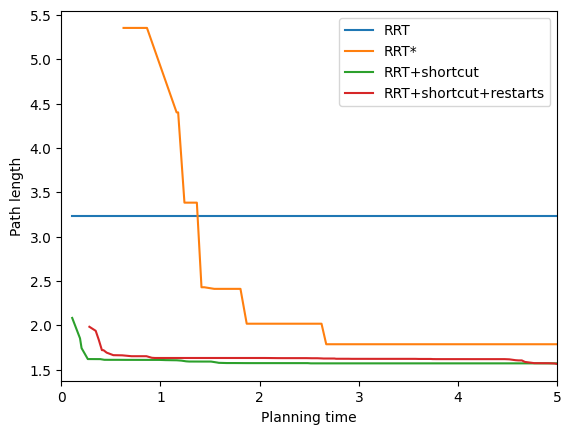

In [4]:
# Figure 12 (interactive): optimizing probabilistic roadmaps with articulated robot
from klampt import *
from klampt import vis
from klampt.plan import robotplanning 
from klampt.math import se3,so3,vectorops
import matplotlib.pyplot as plt
import math
import time

world = WorldModel()
if not world.loadFile("data/tx90l.rob"):
    raise IOError("Couldn't load robot?")
robot = world.robot(0)

obj = world.makeRigidObject("object")
if not obj.geometry().loadFile('data/objects/chair.off'):
    raise IOError("Couldn't load object?")
obj.setTransform(so3.rotation([1,0,0],math.pi/2),[0.5,0.25,0])
obj.appearance().setColor(0,1.0,0.5,1)

qStart = [0,0.5,0.6,-1.3,0,0,0]
qGoal = [0,-1.0,0.8,-1.3,0,0,0]
dofs = [1,2,3,4,5]

planners = {}
robot.setConfig(qStart)
planners['RRT'] = robotplanning.plan_to_config(world,robot,qGoal,movingSubset=dofs,type='rrt',shortcut=0,restart=0,bidirectional=1)
robot.setConfig(qStart)
planners['RRT*'] = robotplanning.plan_to_config(world,robot,qGoal,movingSubset=dofs,type='rrt*',shortcut=0,restart=0)
robot.setConfig(qStart)
planners['RRT+shortcut'] = robotplanning.plan_to_config(world,robot,qGoal,movingSubset=dofs,type='rrt',shortcut=1000,restart=0,bidirectional=1)
robot.setConfig(qStart)
planners['RRT+shortcut+restarts'] = robotplanning.plan_to_config(world,robot,qGoal,movingSubset=dofs,type='rrt',shortcut=100,restart=1,bidirectional=1)

Tmax = 5
plan_increment = 10
planner_cost_trajs = {}
planner_optimal_trajs = {}
for name,P in planners.items():
    print("Planning with",name,"...")
    t0 = time.time()
    cost_traj = []
    y = []
    while time.time() - t0 < Tmax:
        P.planMore(plan_increment)
        t = time.time() - t0
        y = P.getPath()
        if y:
            c = P.pathCost(y)
            if len(cost_traj) == 0 or t > cost_traj[-1][0]+0.01:
                cost_traj.append((t,c))
    planner_cost_trajs[name] = cost_traj
    planner_optimal_trajs[name] = y
    
for name,cost_traj in planner_cost_trajs.items():
    plt.plot([x[0] for x in cost_traj],[x[1] for x in cost_traj],label=name)
plt.xlim(0,Tmax)
plt.legend()
plt.ylabel("Path length")
plt.xlabel("Planning time")
plt.show()

from klampt.model.trajectory import Trajectory
vis.init('HTML')
robot.setConfig(qStart)
vis.add("world",world)
vis.add("start",qStart,color=(0,1,0,0.25))
vis.add("target",qGoal,color=(1,0,0,0.25))
y = planner_optimal_trajs['RRT+shortcut+restarts']
traj = Trajectory(list(range(len(y))),y)
#arc-length parameterize
for i in range(1,len(traj.times)):
    traj.times[i] = traj.times[i-1] + vectorops.distance(traj.milestones[i-1],traj.milestones[i])
dt = 0.05
speed = 0.3
vis.stepAnimation(dt)
t = 0
while t*speed < traj.endTime():
    robot.setConfig(traj.eval(t*speed))
    t += dt
    vis.stepAnimation(dt)
vis.show()

### Common pitfalls in employing PRMs

Sampling-based motion planning is appealing since it can be implemented
for a wide variety of problems by non-planning experts. However, there
are several issues that can cause PRMs to fail. What is often
frustrating is that the PRM will not provide a *rationale* for failure!
It just appears that it just "doesn't work". Some of the most common
pitfalls encountered when implement PRMs and their variants are:

-   Improper handling of non-Euclidean topology of $\mathcal{C}$ in the
    distance metric $d(p,q)$ and dynamic collision checking function.

-   Improper scaling of the C-space / badly scaled distance thresholds
    $R$ or $\delta$.

-   Providing infeasible start and goal configurations.

-   Providing start and goal configurations in "deep pockets": passages
    narrowing down as the endpoint is approached.

-   Incorrect feasibility tests.

-   Applying a planner when the free space volume is negligible, or
    narrow passages are infinitely thin.

When debugging, it is often extremely useful to extract and visually
debug the roadmap produced by a planner. This helps diagnose problems
like the planner taking tiny steps, not expanding the roadmap at all, or
detecting phantom obstacles. This can be tricky in high-dimensional
spaces, since visualization must ultimately take place on a 2D display,
and a roadmap may contain thousands of configurations and edges.

To handle topology, it is extremely important to ensure that the notion
of a "straight line path" in dynamic collision checking interpolates
nearly along a geodesic, and that the distance metric is relatively
close to a geodesic distance. When orientations are present, if this
issue were neglected and the C-space were treated as Euclidean, then
small positive rotations would *never* be connected to small negative
rotations. This will manifest itself as artifacts in which the robot
will either fail to find a path, or will rotate in an unnecessarily long
fashion.

For choosing thresholds, a rule of thumb is to start by setting $R$ and
$\delta$ to be approximately 10% of the diameter of the C-space. The
values can then be fine-tuned to achieve better performance on a given
problem. A good rule of thumb is to aim to achieve approximately 5 &ndash; 15
connections per milestone. This tends to work well for setting the value
of $k$ when $k$-nearest neighbors is used as the nearness criterion in
PRM.

The infeasible endpoint problem is often encountered when there is a bit
of error in the world model or the robot's sensing of its configuration,
and the robot starts or ends at a configuration that is in contact (or
close to it). There are two approaches to handling this: before
planning, adjust the world model so that the robot is collision free
(which can be hard), or slightly perturb $s$ and $g$ to new
configurations $s^\prime$ and $g^\prime$ that are collision free with
respect to the robot's current knowledge. Then, the path is planned
between $s^\prime$ and $g^\prime$, and the robot executes path
$s\rightarrow s^\prime \rightsquigarrow g^\prime \rightarrow g$. This,
however, assumes that the path to the perturbed configurations is
actually feasible in the real world, which requires a bit of care.

The deep pocket problem is faced particularly often in manipulation or
docking, in which the start or goal has the robot touching the obstacle,
and must make a careful, coordinated maneuver to leave it. For example,
when the robot is grasping an object, its fingers are touching both
sides of the object, and the hand must slide carefully in or out of
position without moving laterally or rotating about certain axes. Hence,
the passage is quite narrow in at least 2 or 3 dimensions! In these
pockets of free space, the robot must take shorter steps, and most
directions of travel lead to collision. However, once the pocket is
escaped (like when the hand is away from a grasped object), then large
steps can again be taken. In other words, visibility is nonuniform
across $\mathcal{F}$. There are three general ways of handling this
issue, all of which require studying the manipulation problem more
carefully:

1.  Manually define a short docking/undocking maneuver that inserts into
    / retracts from the pocket. This could be, for example in
    manipulation, a Cartesian move that places the gripper in front of
    the object with fingers wide open. The inverse of this maneuver is
    used to determine the start and goal points for the planner.

2.  Start a tree-growing planner like RRT from the constrained endpoint
    with small step size. After some time, the farthest node from the
    start is assumed to have wiggled out of the pocket and
    point-to-point planning can begin from that new endpoint.

3.  Develop an obstacle-sliding local planner or extension method that
    allows the planner to generate motions that slide against obstacles.

It is easy to make bugs when defining feasibility tests, particularly in
more complex problems where feasibility requires passing many
conditions. This is problematic because the subroutine is the *only*
representation the planner has about the free space, so it needs to
accurately reproduce the C-obstacles of the problem or else the planner
will produce paths that will collide, or fail to find a solution where
one obviously exists. There are some newer techniques that search for a
small set of problematic C-obstacles blocking the way, which can help
debug incorrect settings (Hauser 2012). But perhaps the first approach
to try is to capture statistics during planning to detect the frequency
at which each condition passes and fails inside the test. Some motion
planning libraries will do this automatically and ask the user to define
individual conditions, but in others this is up to the user. If a test
never fails (or always passes) this suggests an obvious implementation
bug.

Finally, the free space must not contain a non-neglible volume
of space (that is, $\mu(\mathcal{F}) / \mu(\mathcal{C})> 0$). This
condition may be produced when a constraint is introduced (like an IK
constraint, or a constraint that two objects must touch, or that a joint
must take on a particular value) that leaves all feasible configurations
on a manifold of lower-dimensionality of space. In these cases, the PRM
will not be able to generate samples with non-neglible probability. One
approach to handle this problem is to parameterize the solution manifold
explicitly. Extensions of PRMs are also available to properly handle
manifold constraints without a need for parameterization; these
techniques generate samples by projecting them onto the feasible
manifold, and also constructing paths that move along the manifold.
These will be discussed later in [Chapter 12.3](AdvancedTopicsInPlanning.ipynb#Manipulation-planning-and-locomotion-planning)

Incomplete Methods
------------------

In addition to the above methods that satisfy some notion of
completeness, there are additional methods based on optimization
techniques that are incomplete: they have no guarantee of finding a
feasible path when one exists. They can, however, generally produce
paths quickly when they do work.

### Potential fields

Potential fields are a well-studied technique that works using only
local information to guide the robot's movement, and is therefore quite
fast, making it appropriate for real-time obstacle avoidance as well as
path planning in relatively simple spaces.

The general idea is to consider the robot's configuration as being a
particle in some energy potential landscape. Due to "gravity" the
particle will feel some virtual forces equal to the negative of the
gradient of this landscape. If the landscape is constructed to have a
global minimum at the goal, then by following the gradient the particle
will, hopefully, arrive at the goal.

To construct such a landscape, the usual method is to combine an
*attractive potential* field in which the force is some gain constant
$k_{att}$ times the vector pointing direction to the goal:
$$P_{att}(q) = \frac{1}{2}k_{att} \| q - q_g \|^2$$ along with a
*repulsive potential* generating a repulsive force for each obstacle.
The repulsive force is chosen to grow larger (typically toward infinity)
as the robot gets closer to the obstacle. Some limiting distance
$\rho_0$ is typically chosen where the effect of an obstacle drops off
to 0. One such function is the following:
$$P_{rep}(q) = \left\lbrace \begin{array}{ll} 
\frac{1}{2}k_{rep}(1/\rho(q) - 1/\rho_0)^2  &  \text{If }\rho(q) \leq \rho_0\\
0 & \text{If }\rho(q) > \rho_0
\end{array}\right.$$ Here $\rho(q)$ is a function that measures the
workspace distance between the robot and the obstacle, and $k_{rep}$
modulates the strength of the force. The potential is infinity at
$\rho(q)=0$ and drops down to 0 at $\rho(q) = \rho_0$. (Note that here
we must be able to calculate distance rather than just Boolean collision
detection.)

The force acting on the particle is the negated gradient of each
potential: $$f_{att}(q) = -k_{att} (q - q_g)$$ and
\begin{equation}
f_{rep}(q) = \left\lbrace \begin{array}{ll} 
k_{rep} (\frac{1}{\rho(q)} - \frac{1}{\rho_0})\frac{1}{\rho(q)^2} 
\frac{\partial \rho(q)}{\partial q}  
&  \text{If }\rho(q) \leq \rho_0\\
0 & \text{If }\rho(q) > \rho_0
\end{array}\right.
\label{eq:RepulsivePotential}
\end{equation}

Then, to evolve the configuration over time as a particle in this
potential field, we use an iterative approach. At the current time step,
the robot is at position $q_t$. The next point along the path is given
by: $$q_{t+1} = q_t + \frac{\Delta t}{m}(f_{att}(q) + f_{rep}(q))$$
where $m$ is a virtual "mass" of the robot and $\Delta t$ is the time
step. One potential issue with this method is that the magnitude of the
force vector can be highly varying, from 0 at the goal to infinity at
the boundary of an obstacle. To avoid huge jumps (or little movement at
all) in the path it makes sense to dynamically set the mass to be
proportional to the magnitude of the force. In this way, consistent rate
of progress is ensured as the path evolves.



In [1]:
# Figure 13 (interactive): potential field approach with articulated robot
from klampt import *
from klampt.math import vectorops,so3
from klampt import vis
import math

world = WorldModel()
if not world.loadFile("data/tx90l.rob"):
    raise IOError("Couldn't load robot?")
robot = world.robot(0)

obj = world.makeRigidObject("object")
if not obj.geometry().loadFile('data/objects/chair.off'):
    raise IOError("Couldn't load object?")
obj.setTransform(so3.rotation([1,0,0],math.pi/2),[0.5,0.25,0])
obj.appearance().setColor(0,1.0,0.5,1)

q = [0,0.5,0.6,-1.3,0,0,0]
q0 = q
qGoal = [0,-1.0,0.8,-1.3,0,0,0]

robot.setConfig(q)
kAttract = 1.0
kRepulse = 0.01
dMin = 0.25
dt = 0.05

def distance(q):
    robot.setConfig(q)
    dmin = float('inf')
    for i in range(robot.numLinks()):
        result = robot.link(i).geometry().distance(obj.geometry())
        dmin = min(dmin,result.d)
    return dmin

def distance_gradient(q):
    robot.setConfig(q)
    dmin = float('inf')
    resultmin = None
    resultlink = None
    settings = DistanceQuerySettings()
    for i in range(robot.numLinks()):
        settings.upperBound = dmin
        result = robot.link(i).geometry().distance_ext(obj.geometry(),settings)
        if result.d < dmin:
            resultmin = result
            resultlink = i
            dmin = result.d
    assert resultmin.hasClosestPoints
    J = robot.link(resultlink).getPositionJacobian(robot.link(resultlink).getLocalPosition(resultmin.cp1))
    direction = vectorops.unit(vectorops.sub(resultmin.cp1,resultmin.cp2))
    d = resultmin.d
    scale = kRepulse*(1/d - 1/dMin)*(1/d**2)
    vis.add("force",[[v for v in resultmin.cp1],vectorops.madd(resultmin.cp1,direction,scale)],color=(1,0.5,0,1))
    return J.T.dot(direction)

def f_att(q):
    return vectorops.mul(vectorops.sub(q,qGoal),-kAttract)

def f_rep(q):
    d = distance(q)
    if d <= 0:
        return [0]*len(q)
    if d > dMin:
        return [0]*len(q)
    grad = distance_gradient(q)
    scale = kRepulse*(1/d - 1/dMin)*(1/d**2)
    return vectorops.mul(grad,scale)

vis.init('HTML')
vis.add("world",world)
vis.add("target",qGoal,color=(1,0,0,0.25))
vis.stepAnimation(dt)
qmin,qmax = robot.getJointLimits()
for t in range(100):
    q = robot.getConfig()
    f = vectorops.add(f_att(q),f_rep(q))
    q = vectorops.madd(q,f,dt)
    for i in range(len(q)):
        q[i] = min(qmax[i],max(qmin[i],q[i]))
    robot.setConfig(q)
    vis.stepAnimation(dt)
vis.show()

This method works well when the robot simply needs to move slightly away
from a straight line path to avoid obstacles, provided that obstacles
are relatively convex and spatially distant. Its main advantages are 1)
speed of computation, and 2) only local information about obstacles is
needed. However, like other local methods it is prone to local minima
caused either by concave obstacles, or narrow passages where the
repulsive forces from either side of the passage cancel out the
attractive force.

### Trajectory optimization

Trajectory optimization is another potential-based method that optimizes
the overall shape of the robot's path to minimize cost. Unlike potential
fields, for which the optimization variable is the configuration of a
single point in time, trajectory optimization uses some parameterization
of the *entire* path as the optimization variable. This helps it avoid
future obstacles and, in some cases, avoid local minima that potential
fields would fall prey to.  Another common use of trajectory optimization is
as a postprocessor for global planners such as grid-based A* or RRT to improve
the quality of the resulting path.


***************

<a name="fig:TrajectoryOptimization"></a>

(a) Parameterizing an initial path | (b) Constrained optimization
-----------------------------------|------------------------------------
<img src="figures/planning/trajectory_optimization1.svg" width="300px"> | <img src="figures/planning/trajectory_optimization2.svg" width="300px">

(c) Collocation methods | (d) Penalty methods 
-----------------------------------|------------------------------------
<img src="figures/planning/trajectory_optimization3.svg" width="300px"> | <img src="figures/planning/trajectory_optimization4.svg" width="300px">


<div class="figcaption"><b>Figure 14</b>.
(a) A 6-segment path connecting a start and goal is parameterized by the coordinates of the 5 intermediate milestones.
(b) An optimized path after applying constrained optimization to minimize path length and keep the milestones out of obstacles. Dotted lines indicate obstacle distance functions, and red arrows indicate local negative gradients at each milestone. Only the fourth milestone reaches an obstacle constraint. 
(c) Additional collocation points, illustrated as white circles, can be added to prevent segments from penetrating obstacles.
(d) Penalty methods push milestones further from obstacles at the expense of longer path length. An an optimum, the negative gradients of the obstacle potentials (brown and cyan arrows) balance the negative gradients of the objective function (red arrows).  A benefit of penalty methods is that they allow unconstrained optimization methods to be used, and these tend to be simpler to implement than constrained optimization methods.
</div>

***************

#### Parameterizing a path

Trajectory optimization begins with the definition of a *parameterized path
repesentation* in which the shape of a candidate path $y(s)$ is dictated by a fixed
number of *path parameters* $\theta \in \mathbb{R}^N$. One example is the class of
piecewise linear paths that connect the start and the goal configurations with
$k$ straight-line segments.  A path interpolates between
milestones $q_0=q_s, q_1, \ldots, q_{k-1}, q_k=q_g$, and we can define the shape
of the path by the values of the $k-1$ intermediate milestones.  This gives us
a path parameter
$$\theta = (q_1,\ldots,q_{k-1}).$$
Any value of
$\theta$ dictates the shape of some path, and any piecewise linear path
with $k$ segments corresponds to some value of $\theta$ ([Figure 13.a](#fig:TrajectoryOptimization)). To make this
dependence clear, we shall refer to the path defined by a value
$\theta$ as $y_\theta$.

If the dimension of C-space is $d$, then $N = d(k-1)$. Hence the
trajectory optimization problem can be quite high dimensional (hundreds
or thousands of dimensions) even for C-spaces with a moderate number of
dimensions.


#### Encoding objective functions

Next, we must encode the objective function as a function of the path parameters. For
minimizing path length, it may be tempting to initially define the
following cost function that minimizes path length:
$$f(\theta) = \sum_{i=1}^k \| q_i - q_{i-1} \|.$$
However, this
formulation has the drawback that it is not differentiable when two
milestones are equal, and also has a null direction when three
milestones are on the straight line. It is more numerically convenient
to minimize the sum of squared distances
$$f(\theta) = \sum_{i=1}^k \| q_i - q_{i-1} \|^2.$$ 
It can be shown that minimizing the sum-of-squares
objective function does indeed minimize path length (as $k$ grows large)
and ensures that milestones are evenly spaced.
(Proving this fact involves a nuanced argument using arc-length parameterizations
and the Cauchy-Schwarz inequality, so we omit it here.)

This objective function can be thought of as an energy function that treats the path
like an "elastic band". The energy minimum is reached when the band is taut
(i.e., milestones are along a straight line).  We will need to encode how the
C-obstacles in a way that prevents this elastic band from passing through them.


#### Encoding constraints

Now let us proceed to defining constraints, which we assume are in the
form $g(q) \leq 0$. As a first step, one might choose to simply enforce
constraints on the milestones:
$$h(\theta) = \begin{bmatrix}{g(q_1)} \\ {\vdots} \\ {g(q_{k-1})} \end{bmatrix} \leq 0.$$
The resulting problem to minimize $f(\theta)$ while enforcing $h(\theta) \leq 0$ is a
*constrained optimization* problem
([Appendix B.3](Optimization.ipynb#Constrained-Optimization)), which can be solved using a
nonlinear program solver, like Sequential Quadratic Programming (SQP).
Efficient implementations will take advantage of sparseness in the
constraint Jacobian.

However, since we have only constrained milestones to lie outside of obstacles, this
formulation runs the risk of having two milestones on either side of
an obstacle, with the intermediate segment crossing the obstacle ([Figure 13.b](#fig:TrajectoryOptimization)).
Let's consider how to avoid constraint violations
between milestones.  One approach is to "inflate" obstacles by adding a margin to the constraint equation:
$$g(q) + \gamma \leq 0$$
with $\gamma \geq 0$ the constraint inflation value. After optimization, the milestones will lie a distance of $\gamma$ outside of the obstacles, and if we have chosen $\gamma$ well
(and with a bit of luck) while the path segments may lie clear of the obstacles.  However, this method relies on the hope that the obstacles are not too "sharp" to overlap the intermediate path segment, and also that by inflating obstacles we do not lose much on optimality or cause the optimization problem to become infeasible!

Another way to enforce constraints along segments is the
*collocation point* method. Collocation points are points along the path at which
constraints will be enforced, and these can be spaced across the entire path,
not just the milestones.

Specifically we can define some number $M$ of collocation points at
parameters $s_1,\ldots,s_M \in [0,1]$, usually evenly distributed along
the parameter space $[0,1]$ ([Figure 13.c](#fig:TrajectoryOptimization)). The $j$'th collocation point lies on a
segment indexed by $i_j \in \{1,\ldots,k\}$ and lies a fraction
$u_j \in [0,1]$ along the straight line segment, where these are
determined so that the configuration at the collocation point is:
$$
  y_\theta(s_j) = q_{i_j-1} + u_j (q_{i_j} - q_{i_j-1}).
$$
We then
define many inequality constraints on $\theta$ so that constraints at
each collocation point are enforced:
$$h(\theta) = \begin{bmatrix}{g(y_\theta(s_1))} \\ {\vdots} \\ {g(y_\theta(s_M))} \end{bmatrix} \leq 0.$$
This approach avoids many of the problems of the constraint inflation approach, but usually leads to higher
computational costs because the optimizer must contend with a larger number of inequality constraints ($M > k$).


#### Penalty methods

An alternative and simpler approach lets us use unconstrained optimizations
([Appendix B.3](Optimization.ipynb#Unconstrained-Optimization)) by converting hard
constraints to penalties in the objective function. In this approach we
define a penalty function for violating constraints:
$$
  f_{pen}(\theta) = \sum_{j=1}^M \max(g(y_\theta(s_j)), 0).
$$
Then by minimizing a weighted objective function
$$
  f(\theta) + w f_{pen}(\theta)
$$
using standard nonlinear optimization
techniques (e.g., Quasi-Newton methods), portions of the path for which
constraints are violated will be pushed out of the C-obstacle ([Figure 13.d](#fig:TrajectoryOptimization)) 

However, if $w$ is not set to be sufficiently high, then the optimizer of the
weighted objective function will still slightly overlap with the
obstacle. To address this, we can progressively increase $w$ to reduce
the amount of overlap. To prevent overlap altogether, we can also allow
the constraint violation penalty to extend a distance $\gamma > 0$
outside the region where the constraint is violated.
$$f_{pen}(\theta; \gamma) = \sum_{j=1}^M \max(g(y_\theta(s_j)), -\gamma) + \gamma.$$

This is just one simple encoding of constraint penalties, and we will visit [many more approaches](OptimalControl.ipynb#Methods-for-handling-obstacles-and-constraints) in Chapter 17 when we discuss [optimal control](OptimalControl.ipynb). 

#### Performance characteristics and alternative approaches

Regardless of whether a constrained or unconstrained approach is taken,
there are two major issues with trajectory optimization:

-   The computational cost of optimization depends strongly on the
    number of path parameters and collocation points. If too few path
    parameters are chosen then a feasible path may not be found; if too
    few collocation points are chosen then the path may violate
    constraints.

-   For complex environments, the potential landscape in $\theta$ space
    is littered with local minima (and typically, more minima appear as
    the granularity $k$ of the path grows).

The problem of choosing collocation points can be addressed by
adaptively identifying the point along the path with maximum constraint
violation, in advanced optimization techniques known as *constraint
generation* or *semi-infinite programming*.  Returning again to the example of
[Figure 13.b](#fig:TrajectoryOptimization), you can imagine identifying the point
on the 4th segment that lies deepest within the obstacle. If we were to insert
another milestone along the path at that point, we now have an optimization problem
with 6 milestones. By solving this optimization problem, we will have pushed
that point out and reduced the maximum constraint violation along the path.  Semi-infinite
programming techniques will solve several optimization problems at increasing levels of
discretization, in the hope that it is cheaper to solve multiple smaller optimizations
than one large optimization with many collocation points.

The local minimum problem can be partially addressed either by
initializing the optimizer with a path from some other motion planning
method, like a sampling-based planner, or by using global optimization
techniques. The approach of seeding an optimizer by a sampling-based
planner is fast and often works well. However, does not guarantee a
globally optimal path, because the planner may have produced a seed path
in a suboptimal homotopy class or basin of attraction. Global
optimization may result in better paths, but can be extraordinarily
slow, particularly in high dimensional spaces.


Summary
-------

### Key takeaways

-   Sampling-based motion planners can overcome some limitations of the
    curse of dimensionality. However, they pay a cost in the variance of
    solution quality and running time.

-   The running time of such planners is dependent on the visibility
    characteristics of the free space, which does not directly relate to
    dimensionality. Running times will be fast in spaces of good
    visibility.

-   Probabilistic roadmaps (PRMs) and Rapidly-Exploring Random Trees
    (RRTs) are the most widely used classes of such planners. There are
    many variations on the basic structure.

-   Shortcutting can be employed in postprocessing to achieve fast (but
    local) improvements in path quality. To achieve global improvements,
    optimizing variants of PRMs and RRTs are available.

-   Potential field methods use only local information to determine a
    direction of movement and are extremely fast. They can work well for
    real-time obstacle avoidance, but are prone to local minima.

-   Trajectory optimization methods simultaneously optimize milestones
    along an entire trajectory. However, there are tradeoffs in choosing of the
    number of milestones used to represent a path and how constraints are encoded,
    and they are also prone to local minima.

### Glossary
* [Curse of dimensionality](#Grid-Search-and-the-Curse-of-Dimensionality): a set of problems that occur as the dimensionality of a space increases; most notably for planning, the exponential growth in a regular sampling of the space (e.g., the number of states in a grid search).
* [Probabilistic roadmap planners](#Probabilistic-roadmaps): A class of planners that build a network of randomly sampled configurations in the free space, connected by free-space paths.
* Static collision check
* Dynamic collision check
* Rapidly-exploring random trees
* [Nearest neighbor query](#Nearest-neighbor-queries): A fundamental subroutine in sampling-based planning in which the $k$-closest milestones to a query configuration, out of a set of milestones, are returned.
* [Visibility set](#visibility-set): the visibility set of a configuration $q$ is the set of all configurations that can "see" $q$ with a straight-line path.
* [Potential field planners](#Potential-fields): A class of incomplete planners that incrementally push the configuration toward the goal and away from obstacles using "force fields".
* [Trajectory optimization planners](#Trajectory-optimization): A class of incomplete motion planners that use trajectory optimization in an attempt to find high-quality and collision-avoiding paths.
* [Constrained optimization](#Encoding-constraints): A trajectory optimization formulation in which motion constraints are imposed as hard constraints on the optimization variable.
* [Penalty methods](#Penalty-methods): A trajectory optimization formulation that penalizes constraint violations in the objective function.

Exercises
---------

1. Let $n$ be the number of (feasible) milestones in a probabilistic roadmap, and $N$ be the
   number of configurations sampled.  Prove that if a PRM algorithm is probabilistically complete as $n$
   increases, then it is also probabilistically completeness as $N$ increases, as long as the chance of 
   drawing a feasible sample is nonzero.

1. A PRM with a fixed connection radius $R$ can be thought of as restricting the visibility set of a point to be 
   intersected a neighborhood of radius $R$.  With this interpretation, are the visibility properties of a space
   ($\epsilon$-goodness and $\beta$-expansiveness) dependent on $R$?  Explain why or why not.  How would
   the visibility properties vary depending on whether the distance function was chosen to use an
   $L_1$, $L_2$, or $L_\infty$ metric?

1. Suppose the free space is described by a set of $m$ C-obstacles $C_1,...,C_m$. Let $\mathcal{C}$ be the space
   in which configurations are sampled, and let $\mu$ be the volume measure.  For a sampled configuration $q$,
   what are the probabilities of that $q$ lies within each C-obstacle?  If testing each obstacle has the same
   computational cost, what is the fastest order in which the C-obstacles should be tested?

1. Illustrate a free space in which Lazy PRM is expected to check a large fraction of edges for visibility
   before finding a solution.  Lazy PRM may take more time than a standard PRM in this case.  What component
   of Lazy PRM would be the cause of this computational overhead?

1. Does it make sense to build a lazy PRM in precomputation for multi-query path planning?  If so, give
   some examples of what situations in which this approach would be useful.  If not, explain why not.

1. In our discussion of shortcutting, path length was used as the objective function
   for optimization.  Give an example of an objective function for which shortcutting does not improve the
   path cost.  Then, describe a modification to the shortcutting algorithm so that the objective function
   does not increase.

1. What is the maximum number of static collision checks needed for a PRM to check a path between milestones
   $v_1,...,v_m$, given a fixed resolution of $\epsilon$ for dynamic collision checking?  How many
   static collision checks and distance queries are needed for a PRM to solve a problem, using
   Visible-Exact1 for dynamic collision checking, where the clearance of the path
   $y = v_1 \rightarrow \cdots \rightarrow v_m$ is $\delta$?

1. Implement a brute force $k$-nearest neighbor algorithm that runs in $O(n k)$ time.  Hint: store
   the $k$ nearest neighbors in an array, and maintain the index of the neighbor with maximum distance.
   Can you improve this to $O(n \log k)$ time?

1. Write pseudocode for an $R$-neighborhood query for a $k$-d tree.  Implement this, double checking that
   it works properly compared to a brute-force approach on random datasets.
   
1. In the potential field approach, we need to evaluate the distance field and its gradient when calculating
   the repulsive force \eqref{eq:RepulsivePotential}.  The distance here is expressed in configuration space,
   but we typically do not have direct access to such a function when working with an articulated robot.
   Instead, we are typically able to compute geometry-geometry distances in
   workspace. Show how to evaluate a distance field as a function of configuration, and how to approximate its
   gradient as a function of the configuration variables.  (Hint: forward kinematics and the Jacobian will be used
   here. Assume your geometry-geometry distance function also generates closest points.)

## Interactive quiz

In [ ]:
#This code must be run from the RoboticSystemsBook folder

# If you are running on Google Colab, uncomment the following code:
#
# %cd ~
# !git clone --depth 1 https://github.com/krishauser/RoboticSystemsBook
# %cd RoboticSystemsBook

from rsbook_code.assessment import quiz
quiz.show("motion_planning_higher_dimensions")